In [2]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta, time
import learning_lidar.utils.global_settings as gs
import learning_lidar.utils.vis_utils as vis_utils
import pandas as pd
import learning_lidar.preprocessing.preprocessing as prep
import learning_lidar.preprocessing.preprocessing_utils as prep_utils
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from learning_lidar.generation.daily_signals_generations_utils import get_daily_bg

import learning_lidar.generation.generation_utils as gen_utils
from learning_lidar.dataseting.dataseting import calc_data_statistics
from learning_lidar.utils.proc_utils import  normalize
import learning_lidar.utils.xr_utils as xr_utils

from tqdm import tqdm
vis_utils.set_visualization_settings()

fast_funcs not available


In [3]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       nbins=100, log_scale=False,
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png'):
    date_datetime = prep.get_daily_ds_date ( dataset )
    ds_profile = dataset.get(profile_type)
    df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size %',
                                     'positive %', 'negative %','zeros %',
                                     'mean' , 'std'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),sharey=True)
    ax = axes
    th = gs.eps
    for ind,(wavelength) in enumerate(dataset.Wavelength.values):
        sub_ds = ds_profile.sel(Wavelength = wavelength)
        mask_valid = (~pd.isna(sub_ds.values))
        valid_size = mask_valid.astype(int).sum()
        orig_size = sub_ds.values.size

        # positive values histogram
        pos_ds = sub_ds.where(sub_ds > th).where(sub_ds != np.nan)#.values
        pos_vals = pos_ds.values[~np.isnan(pos_ds.values)]
        pos_size = pos_vals.size

        hist, bins =np.histogram(pos_vals , bins=nbins)
        min_bin = bins[0] if bins[0]>0 else bins[0]+gs.eps
        max_bin = bins[-1]
        logbins = np.logspace(np.log10(min_bin),np.log10(max_bin),len(bins))
        ax.hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
                   alpha=0.4)

        if log_scale:
            ax.set_xscale('symlog')

        #negative values histogram
        neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
        neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
        neg_size = neg_vals.size


        # Zero values histogram
        zero_ds= sub_ds.where(sub_ds >= -th).where(sub_ds <=th).where(sub_ds != np.nan )
        zero_vals= zero_ds.values[~np.isnan(zero_ds.values)]
        zero_size = zero_vals.size

        df_stats.loc[ind] = [wavelength,
                            100.0*valid_size/orig_size,
                            100.0*pos_size/orig_size ,
                            100.0*neg_size/orig_size ,
                            100.0*zero_size/orig_size,
                            sub_ds.mean().values,
                            sub_ds.std().values]
        # TODO : take care of representation after the digit values

    ax.legend()
    min_val, max_val = float(ds_profile.min().values),float(ds_profile.max().values)
    ax.set_xlim([min_val,max_val+0.1*(max_val-min_val)])
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major')

    xlabels = f"{ds_profile.long_name} [{ds_profile.units}]"
    ax.set_xlabel(xlabels, horizontalalignment='center')
    axes.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
    stitle = f"Histogram of {ds_profile.info.lower()} " \
             f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
    fig.suptitle(stitle)

    plt.tight_layout()
    plt.show()

    if SAVE_FIG :
        fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
                f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
        if not os.path.exists ( dst_folder ) :
            try :
                os.makedirs ( dst_folder , exist_ok = True )
                print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
            except Exception :
                raise OSError ( f"Failed to create folder: {dst_folder}" )
        fpath = os.path.join ( dst_folder , fname )
        fig.savefig(fpath,bbox_inches='tight', format = format_fig)
        print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
    return fig,axes,df_stats

In [4]:
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()
dates = [datetime(2017,9,1), datetime(2017,9,2),datetime(2017,10,2),datetime(2017,10,15)]
dt_day = dates[0]
r2_da = prep_utils.calc_r2_ds(station, dt_day)
main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)), 'data')
times = [dt_day+ timedelta(hours=9),
         dt_day+ timedelta(hours=12),
         dt_day+ timedelta(hours=15),
         dt_day+ timedelta(hours=18)]

In [13]:
station.gen_signal_dataset

'D:\\data_haifa\\GENERATION\\signal_dataset'

# 1. Optical Density signal

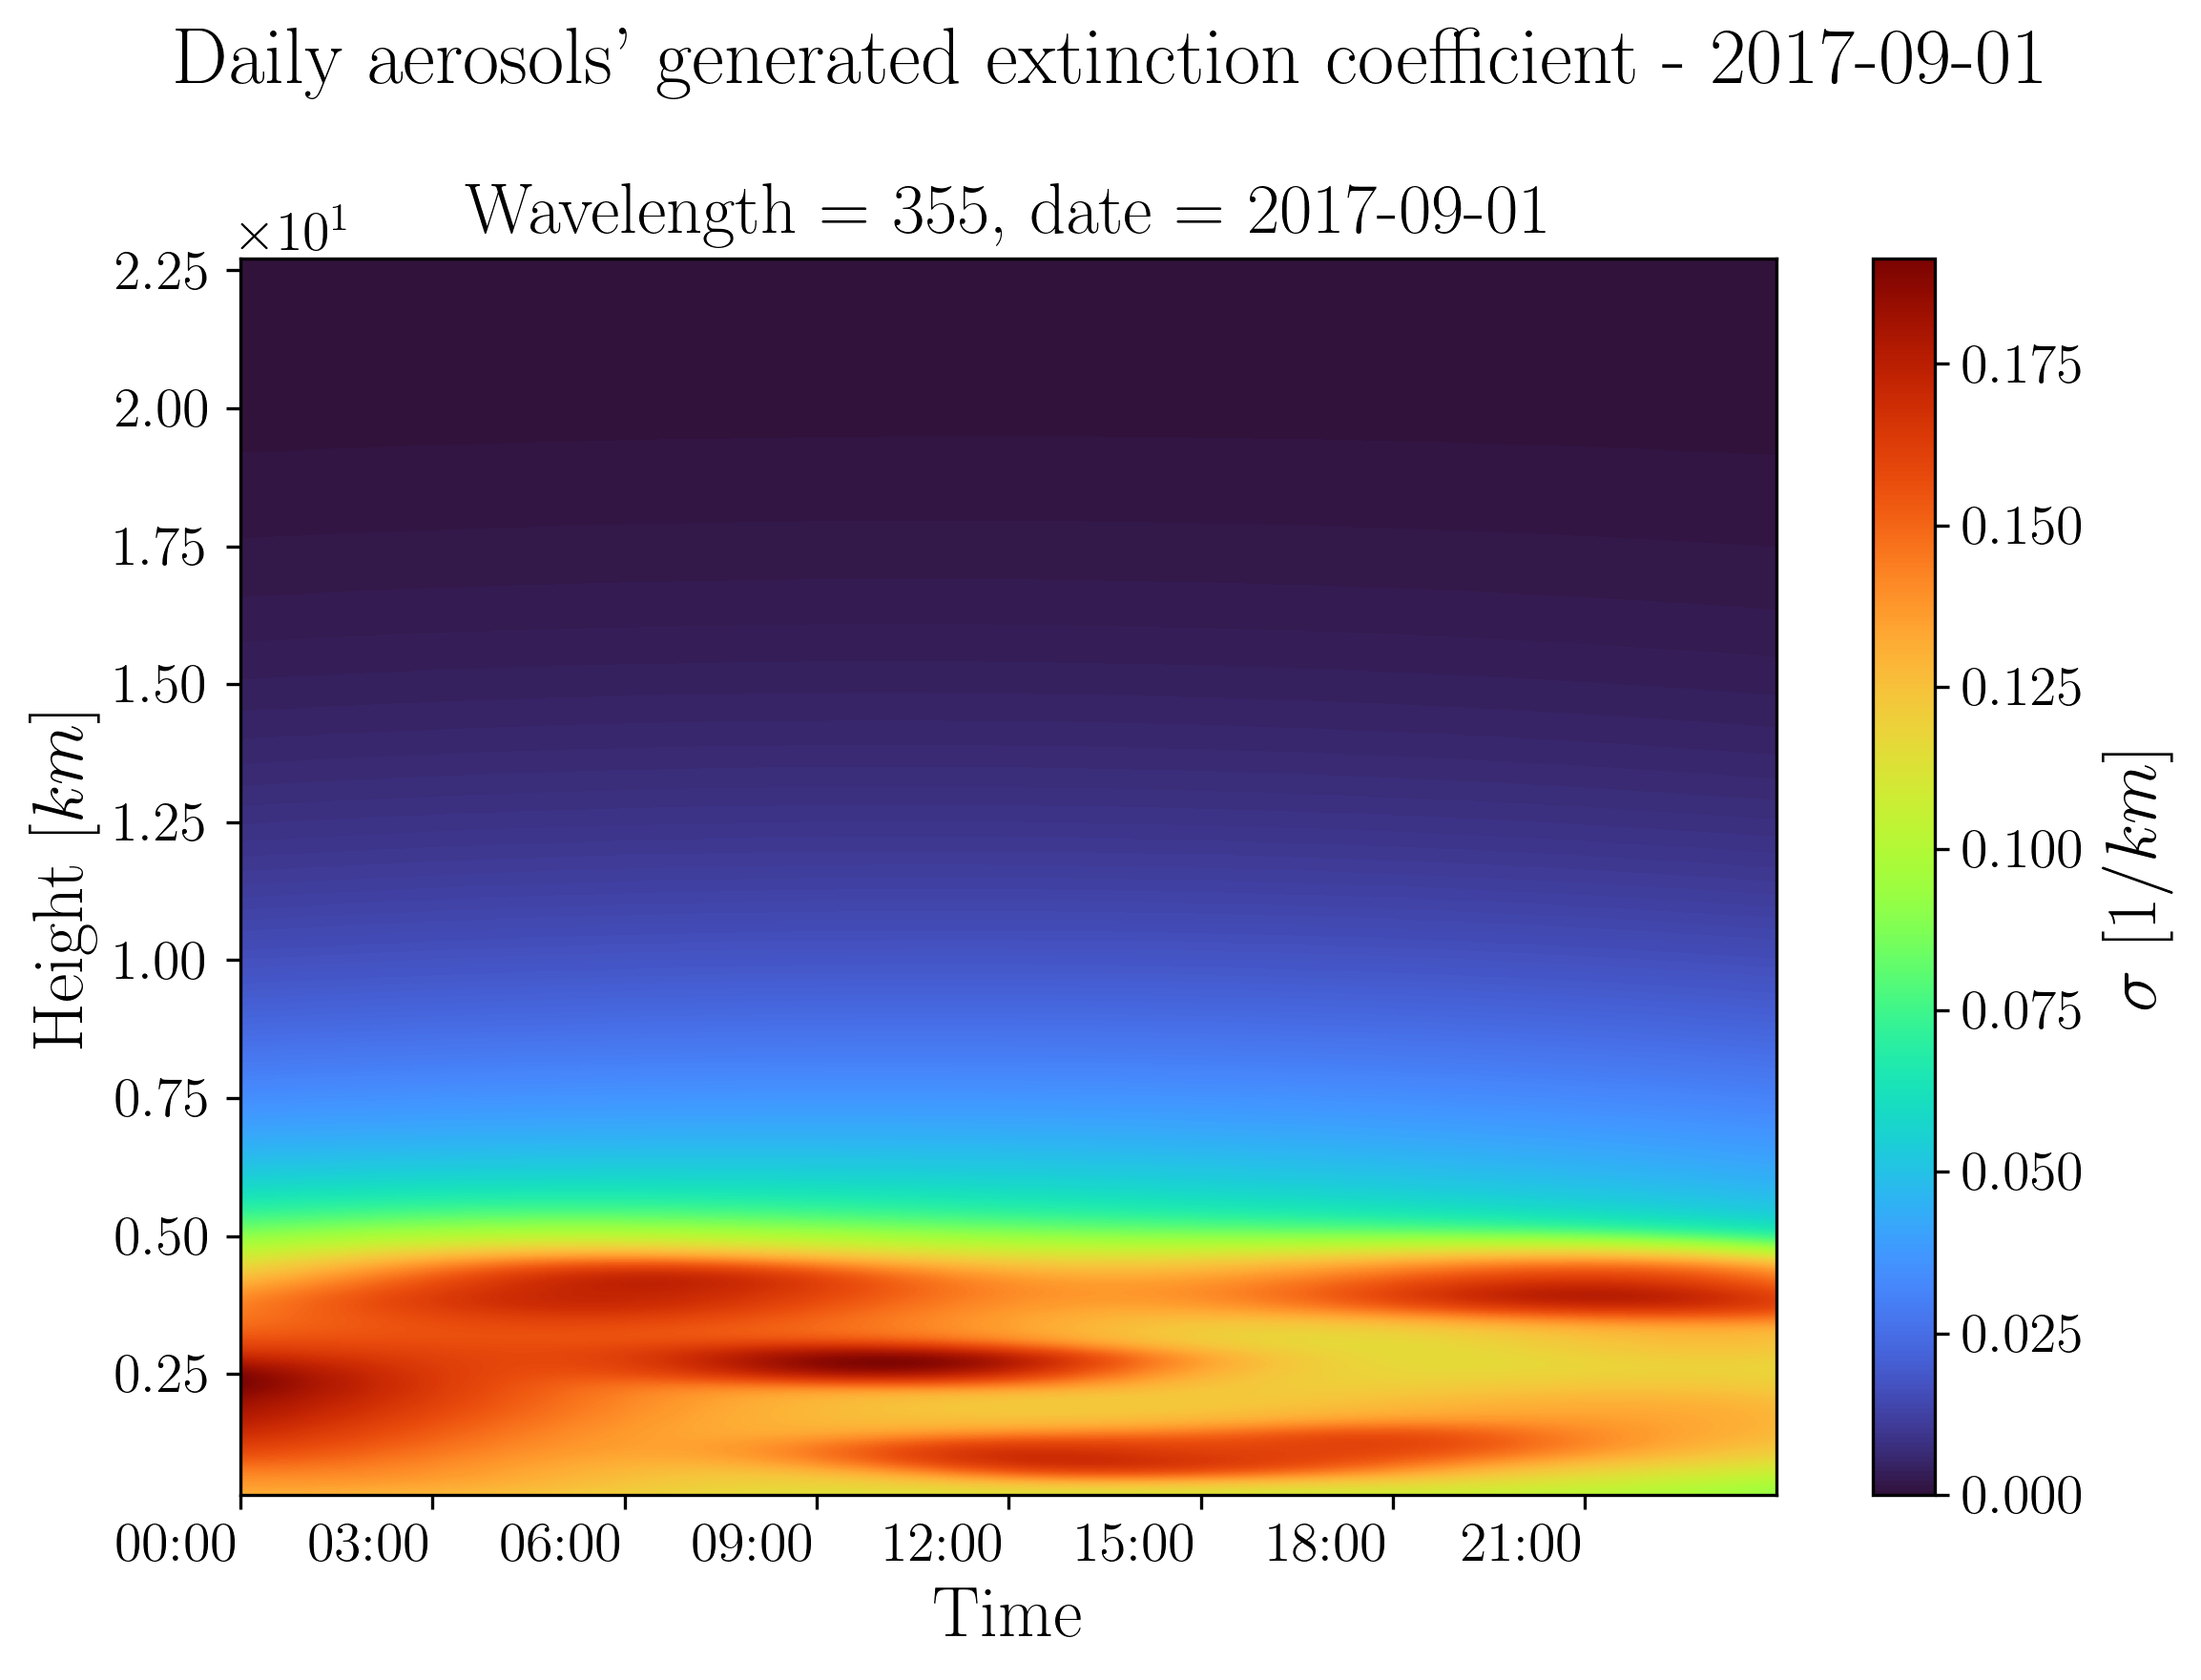

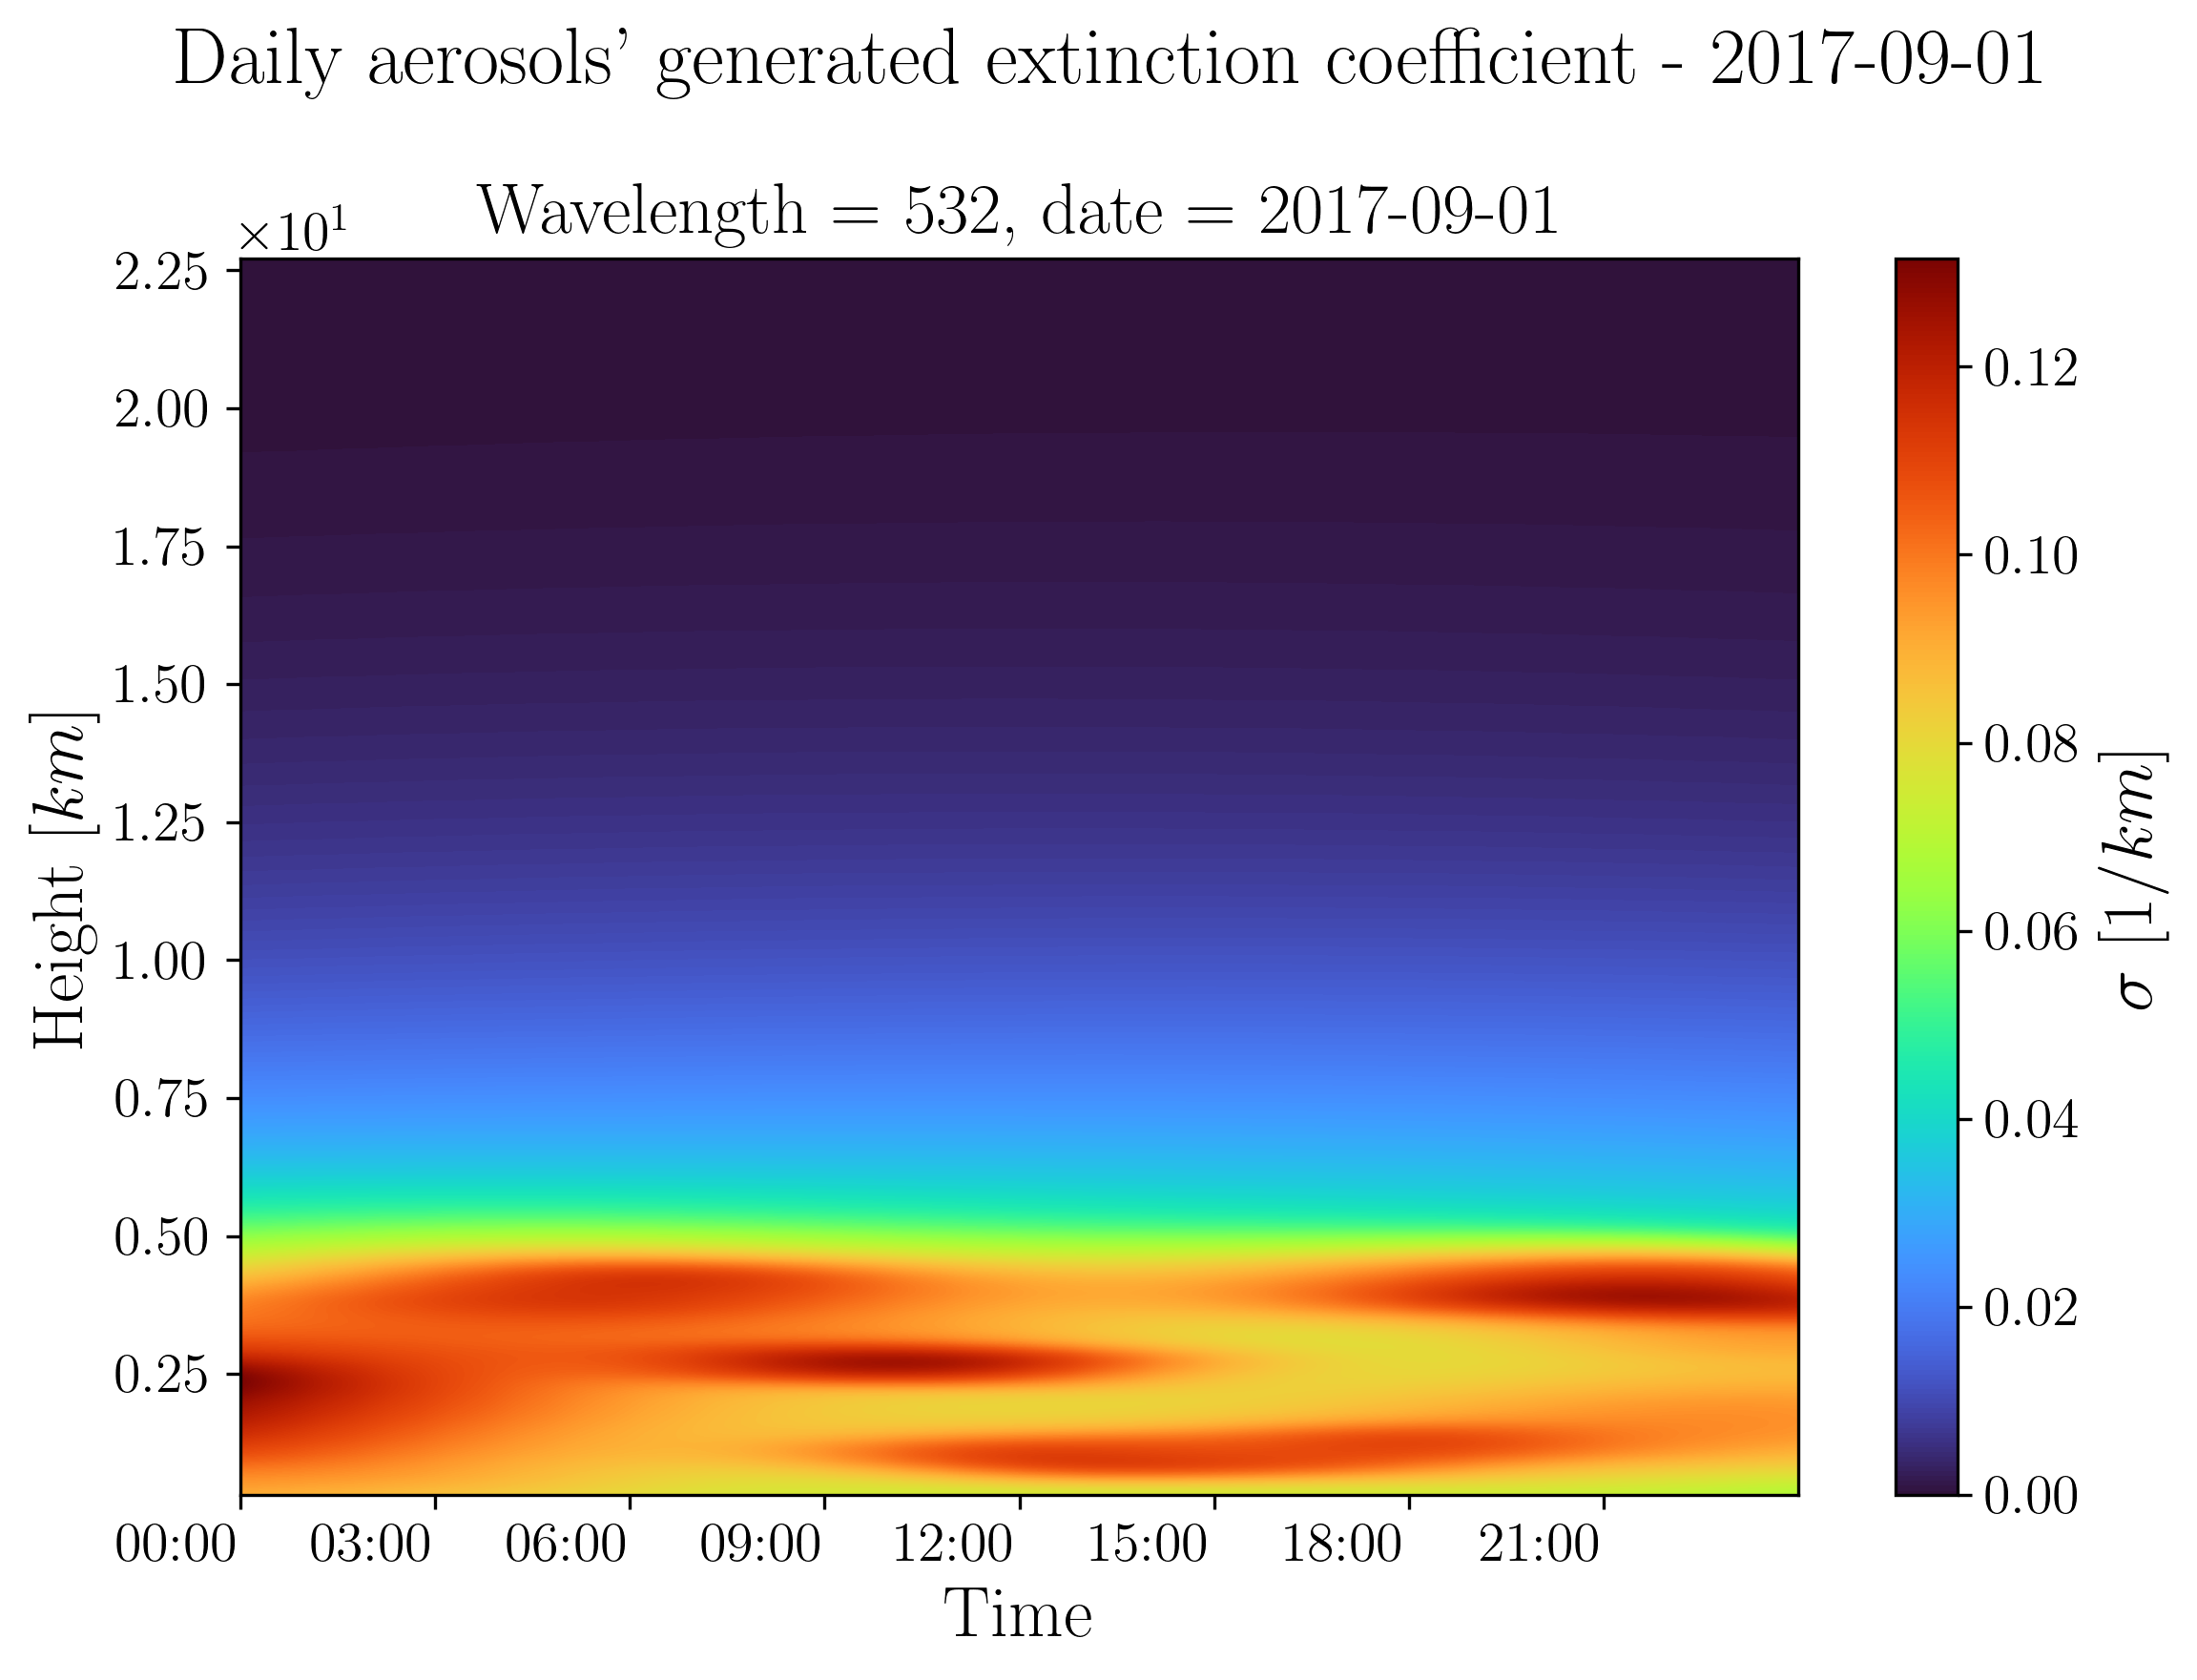

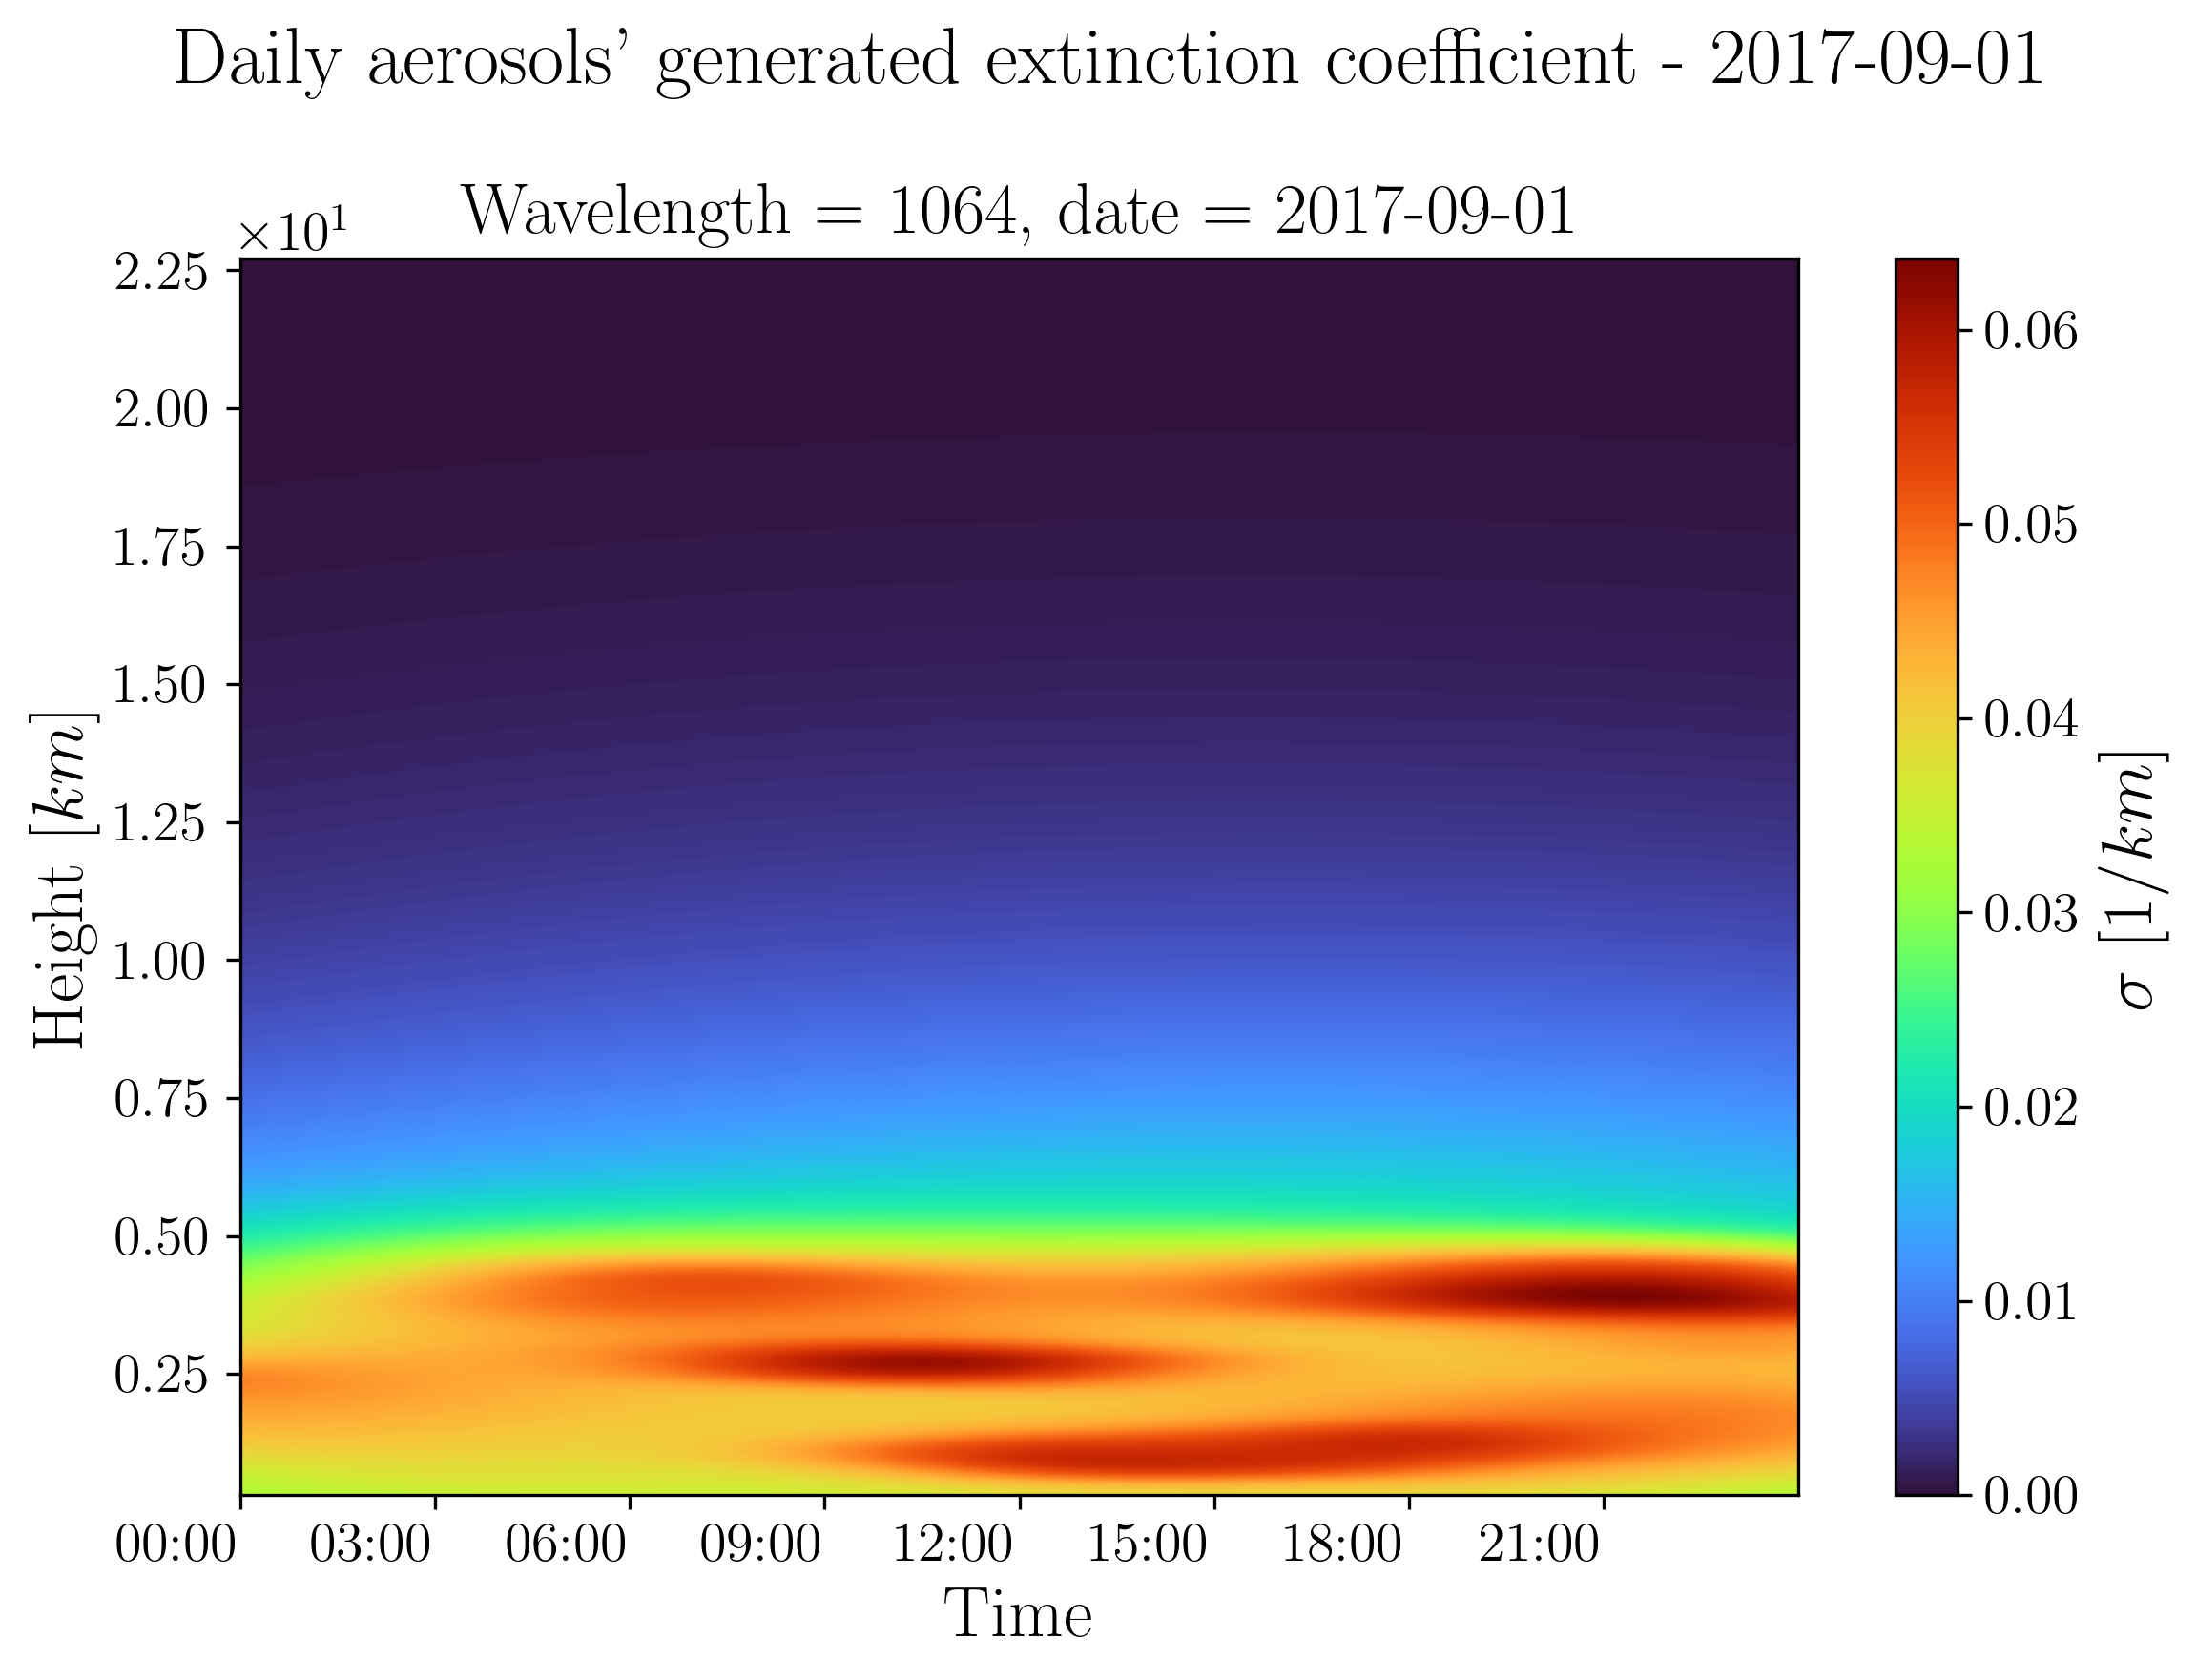

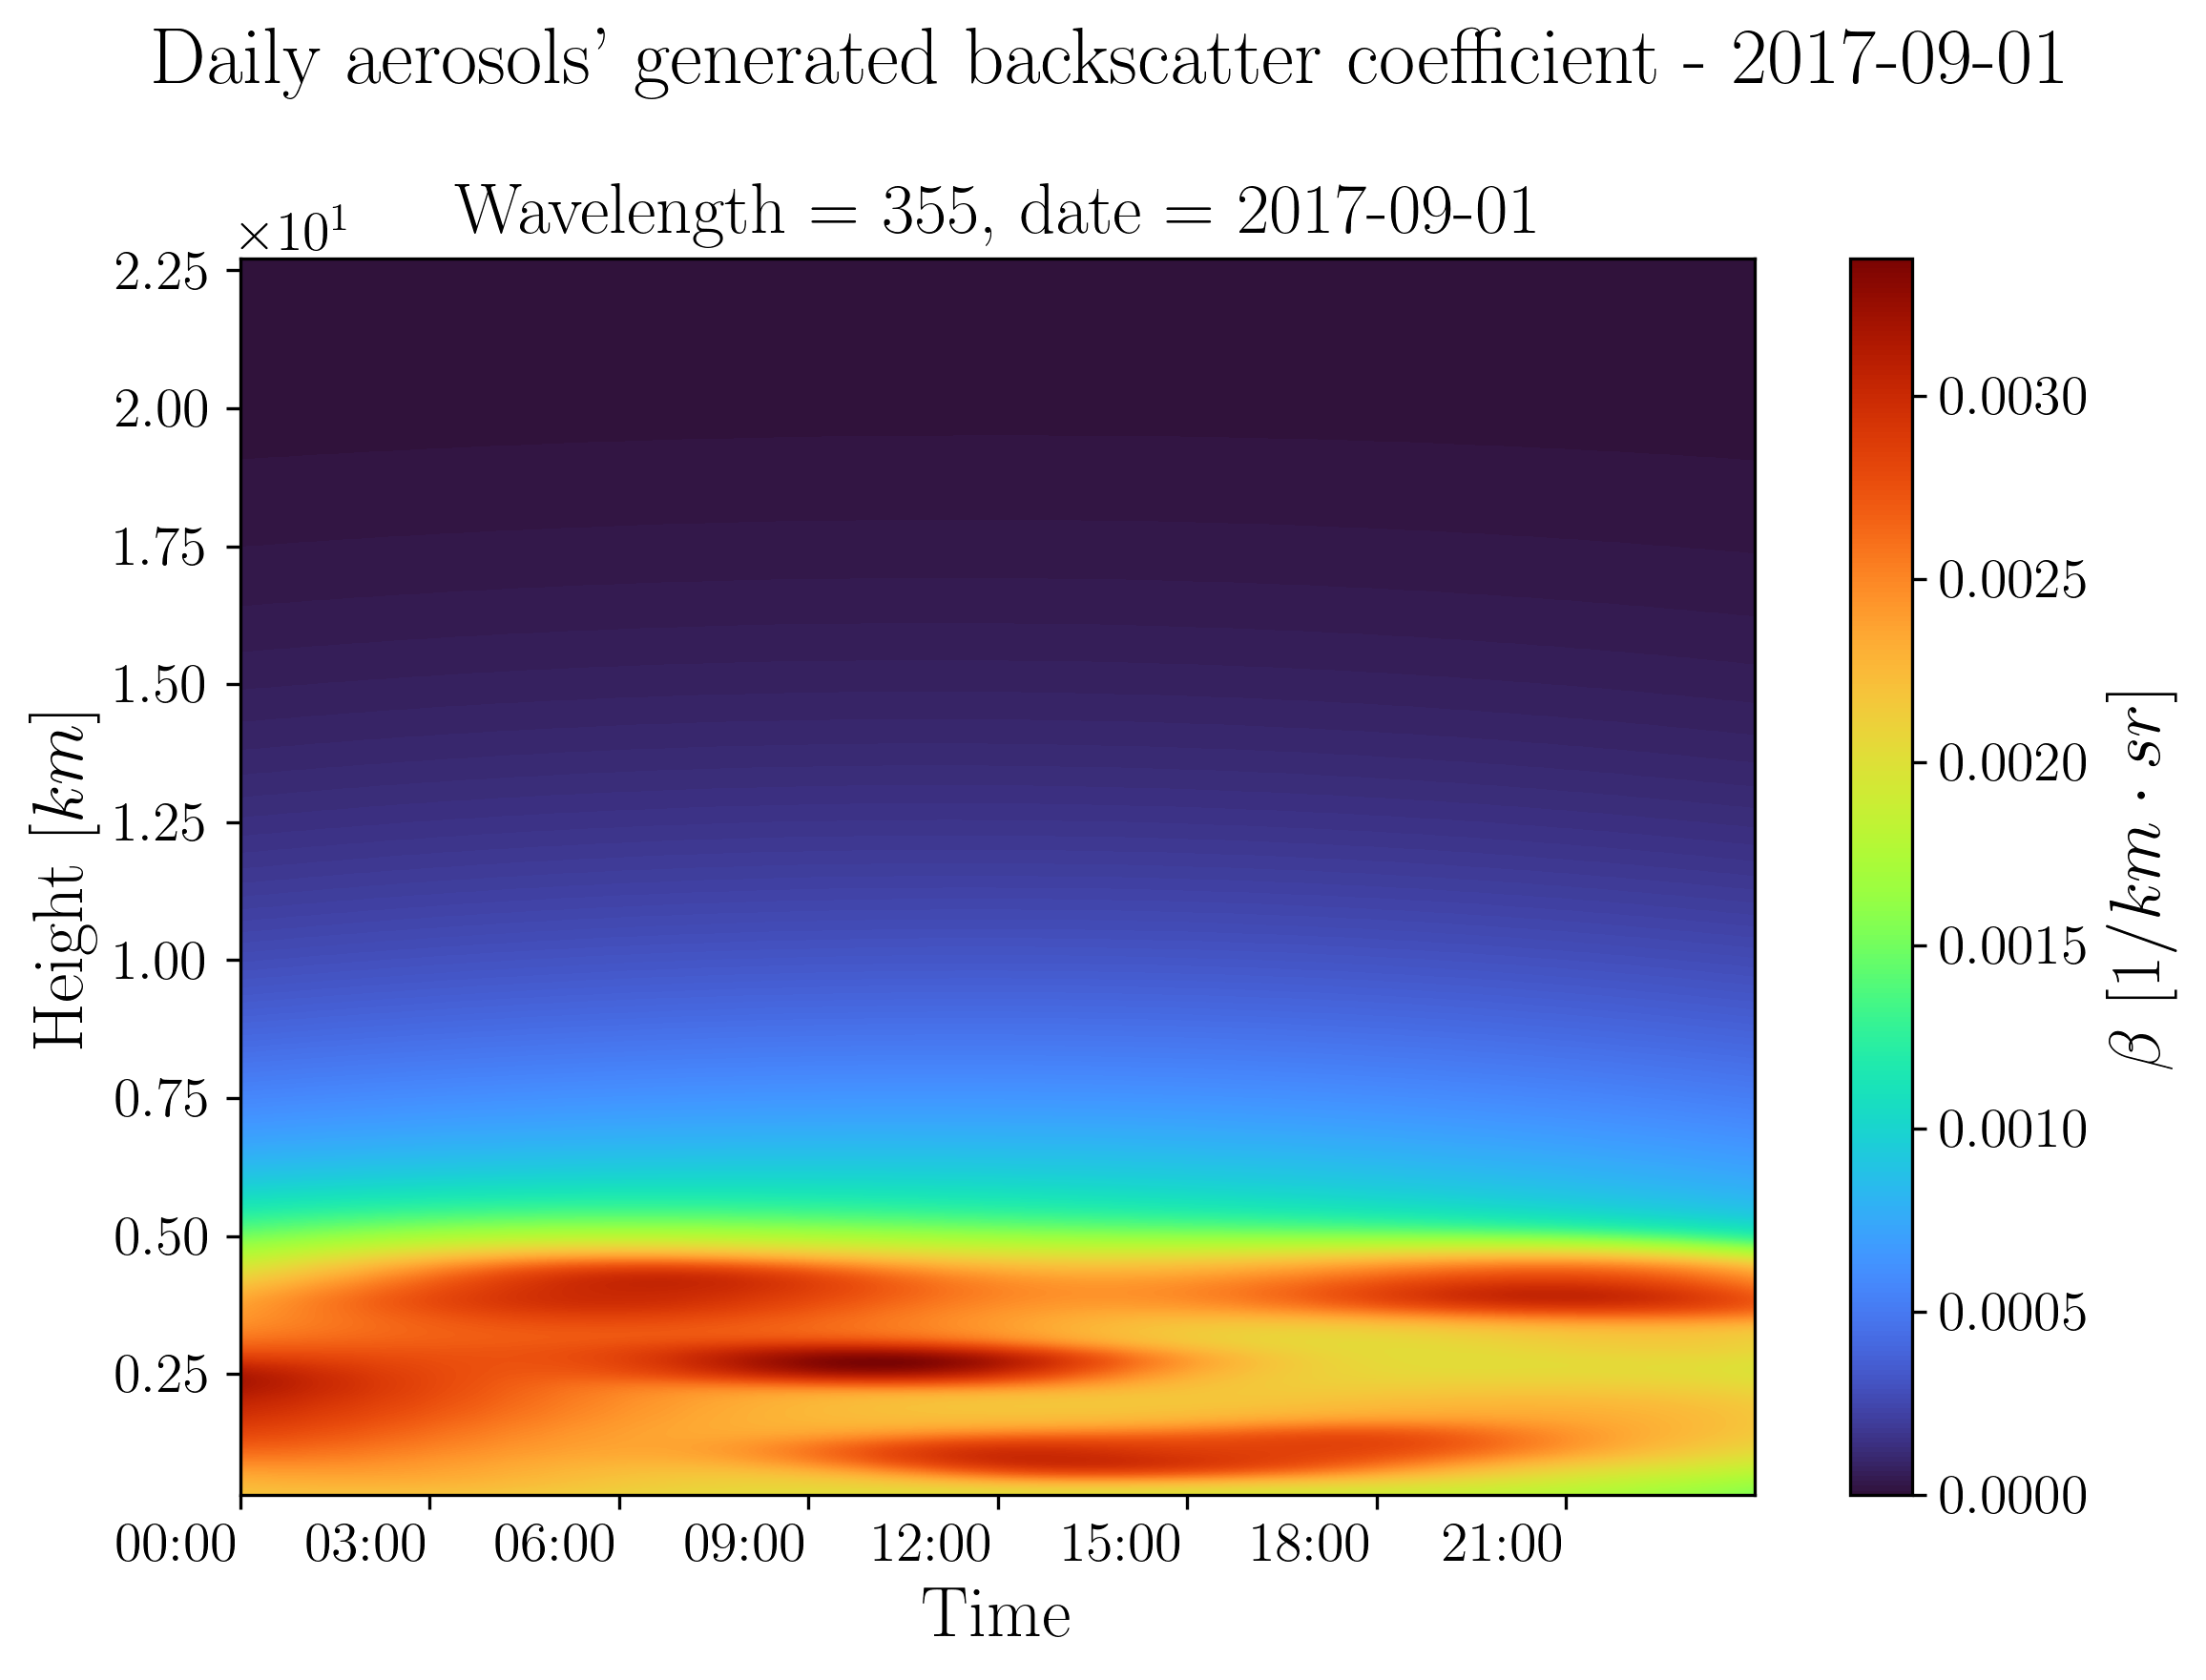

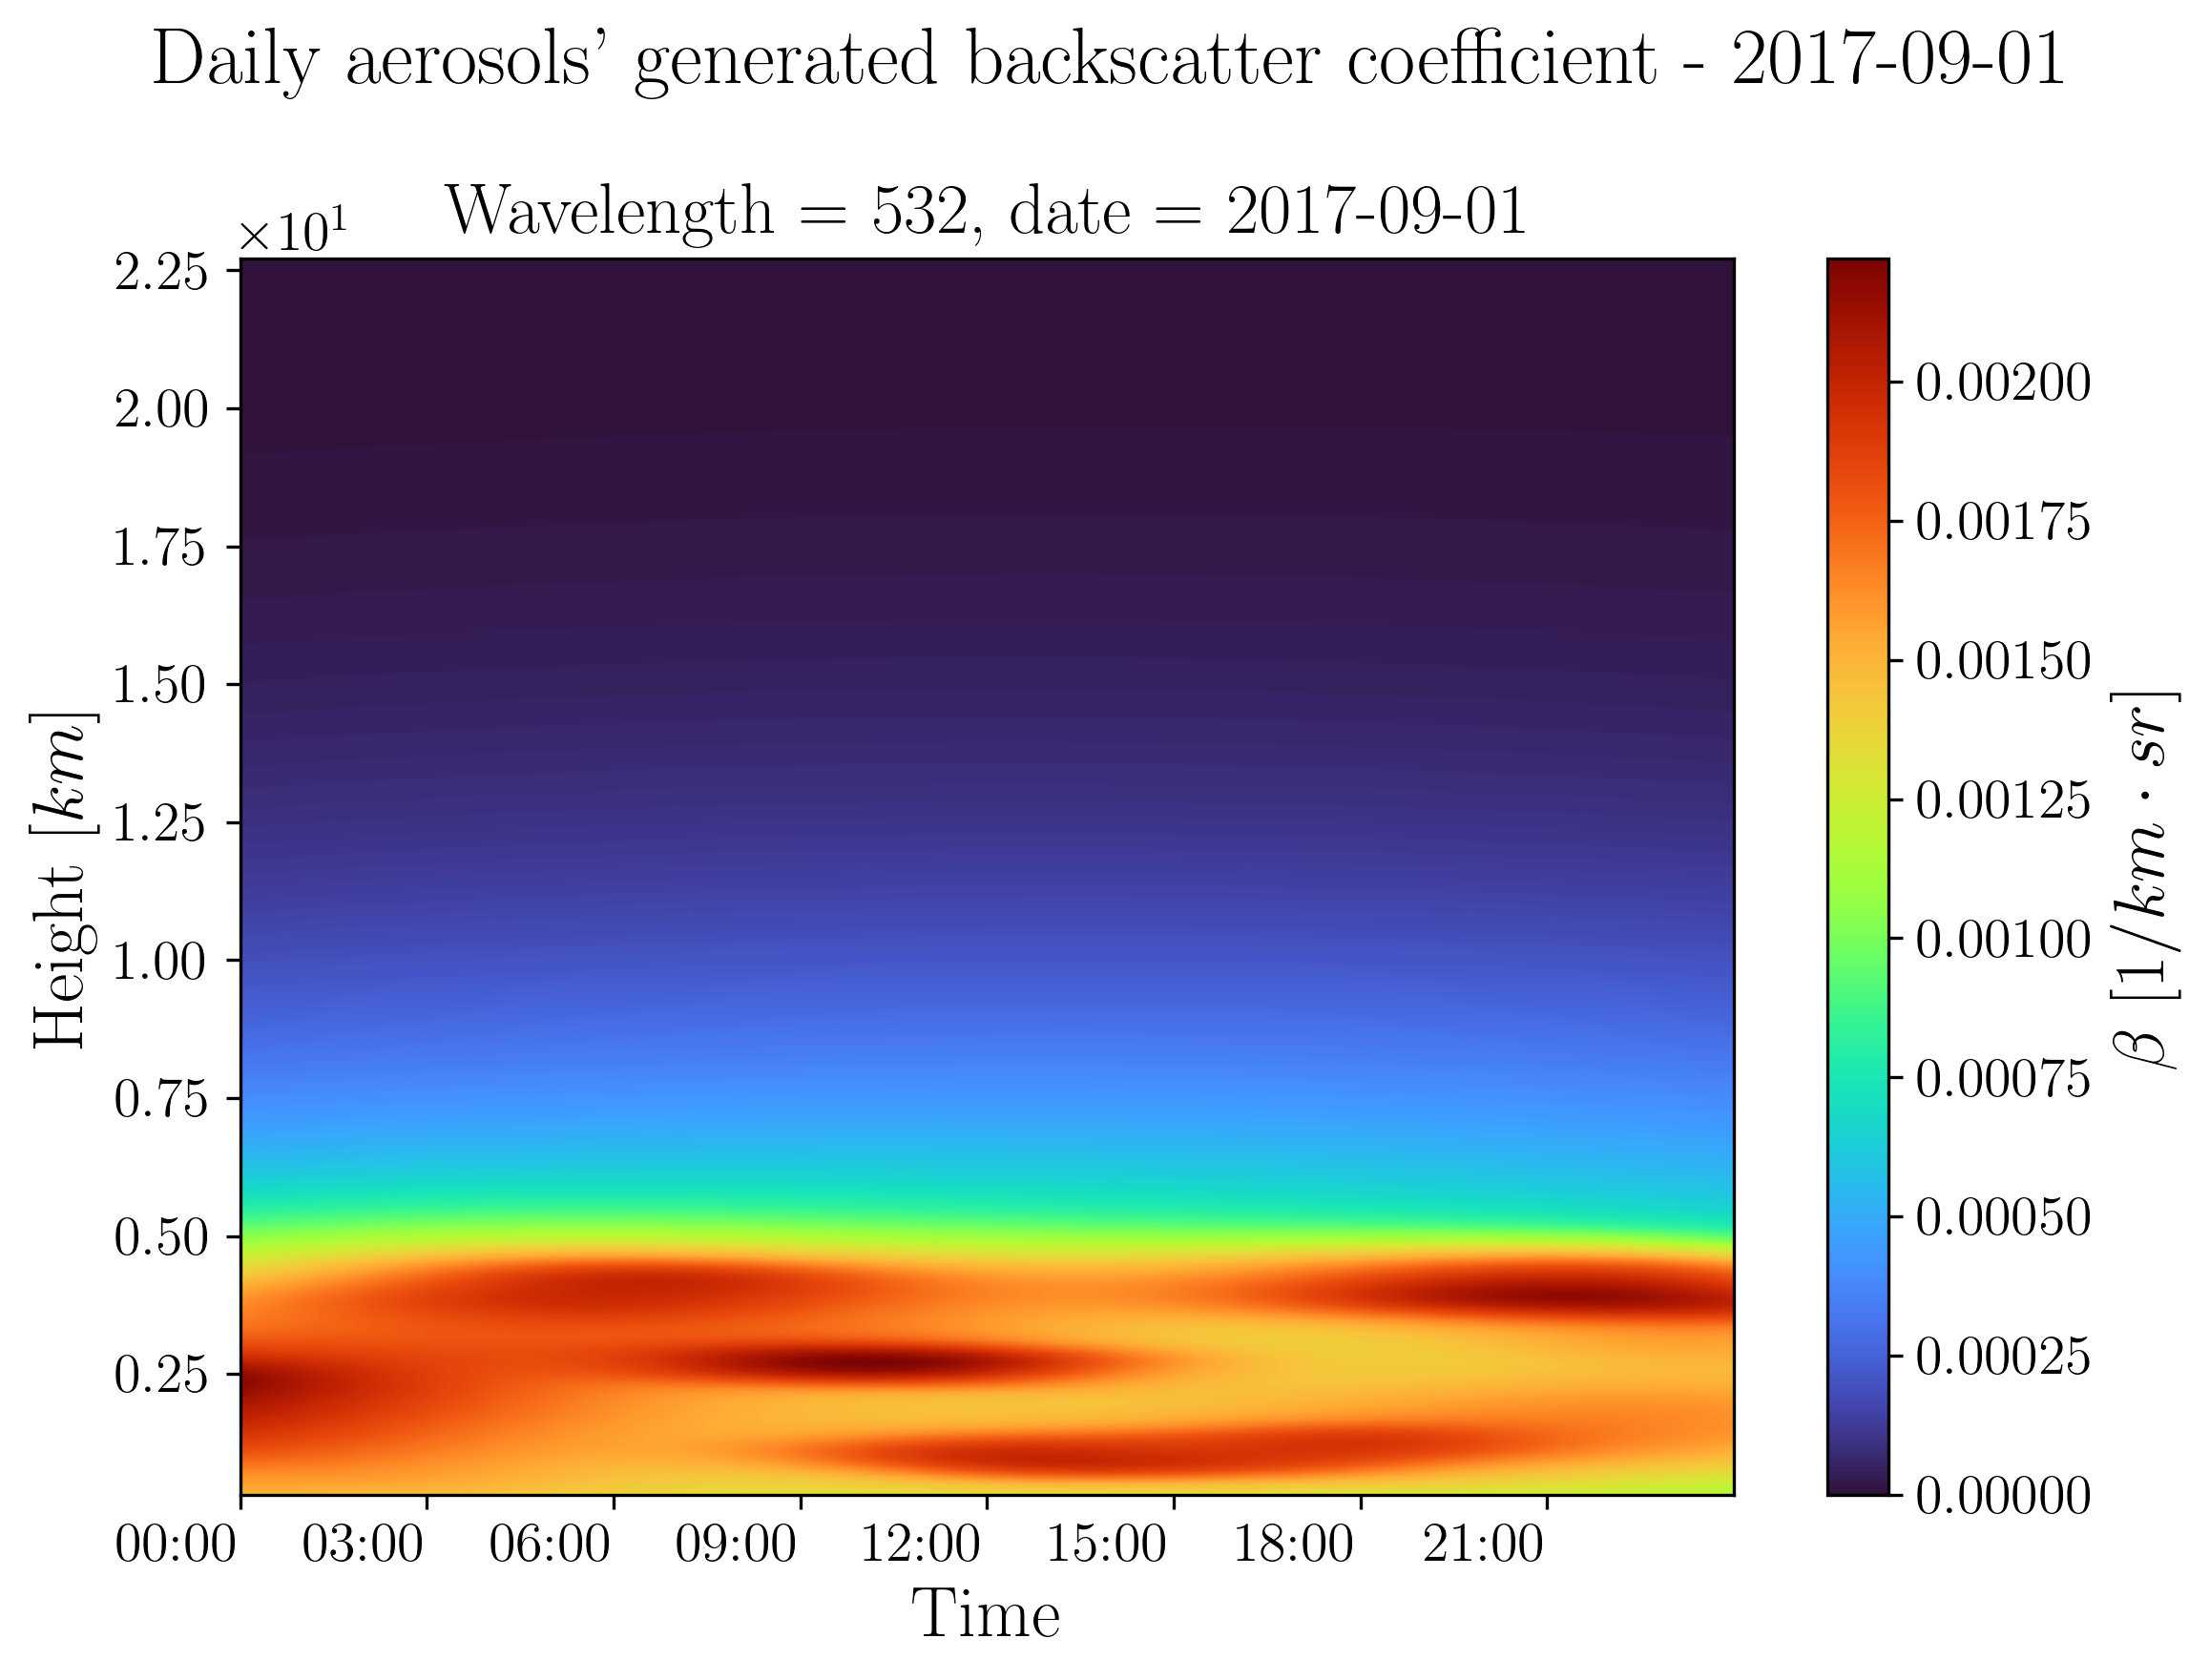

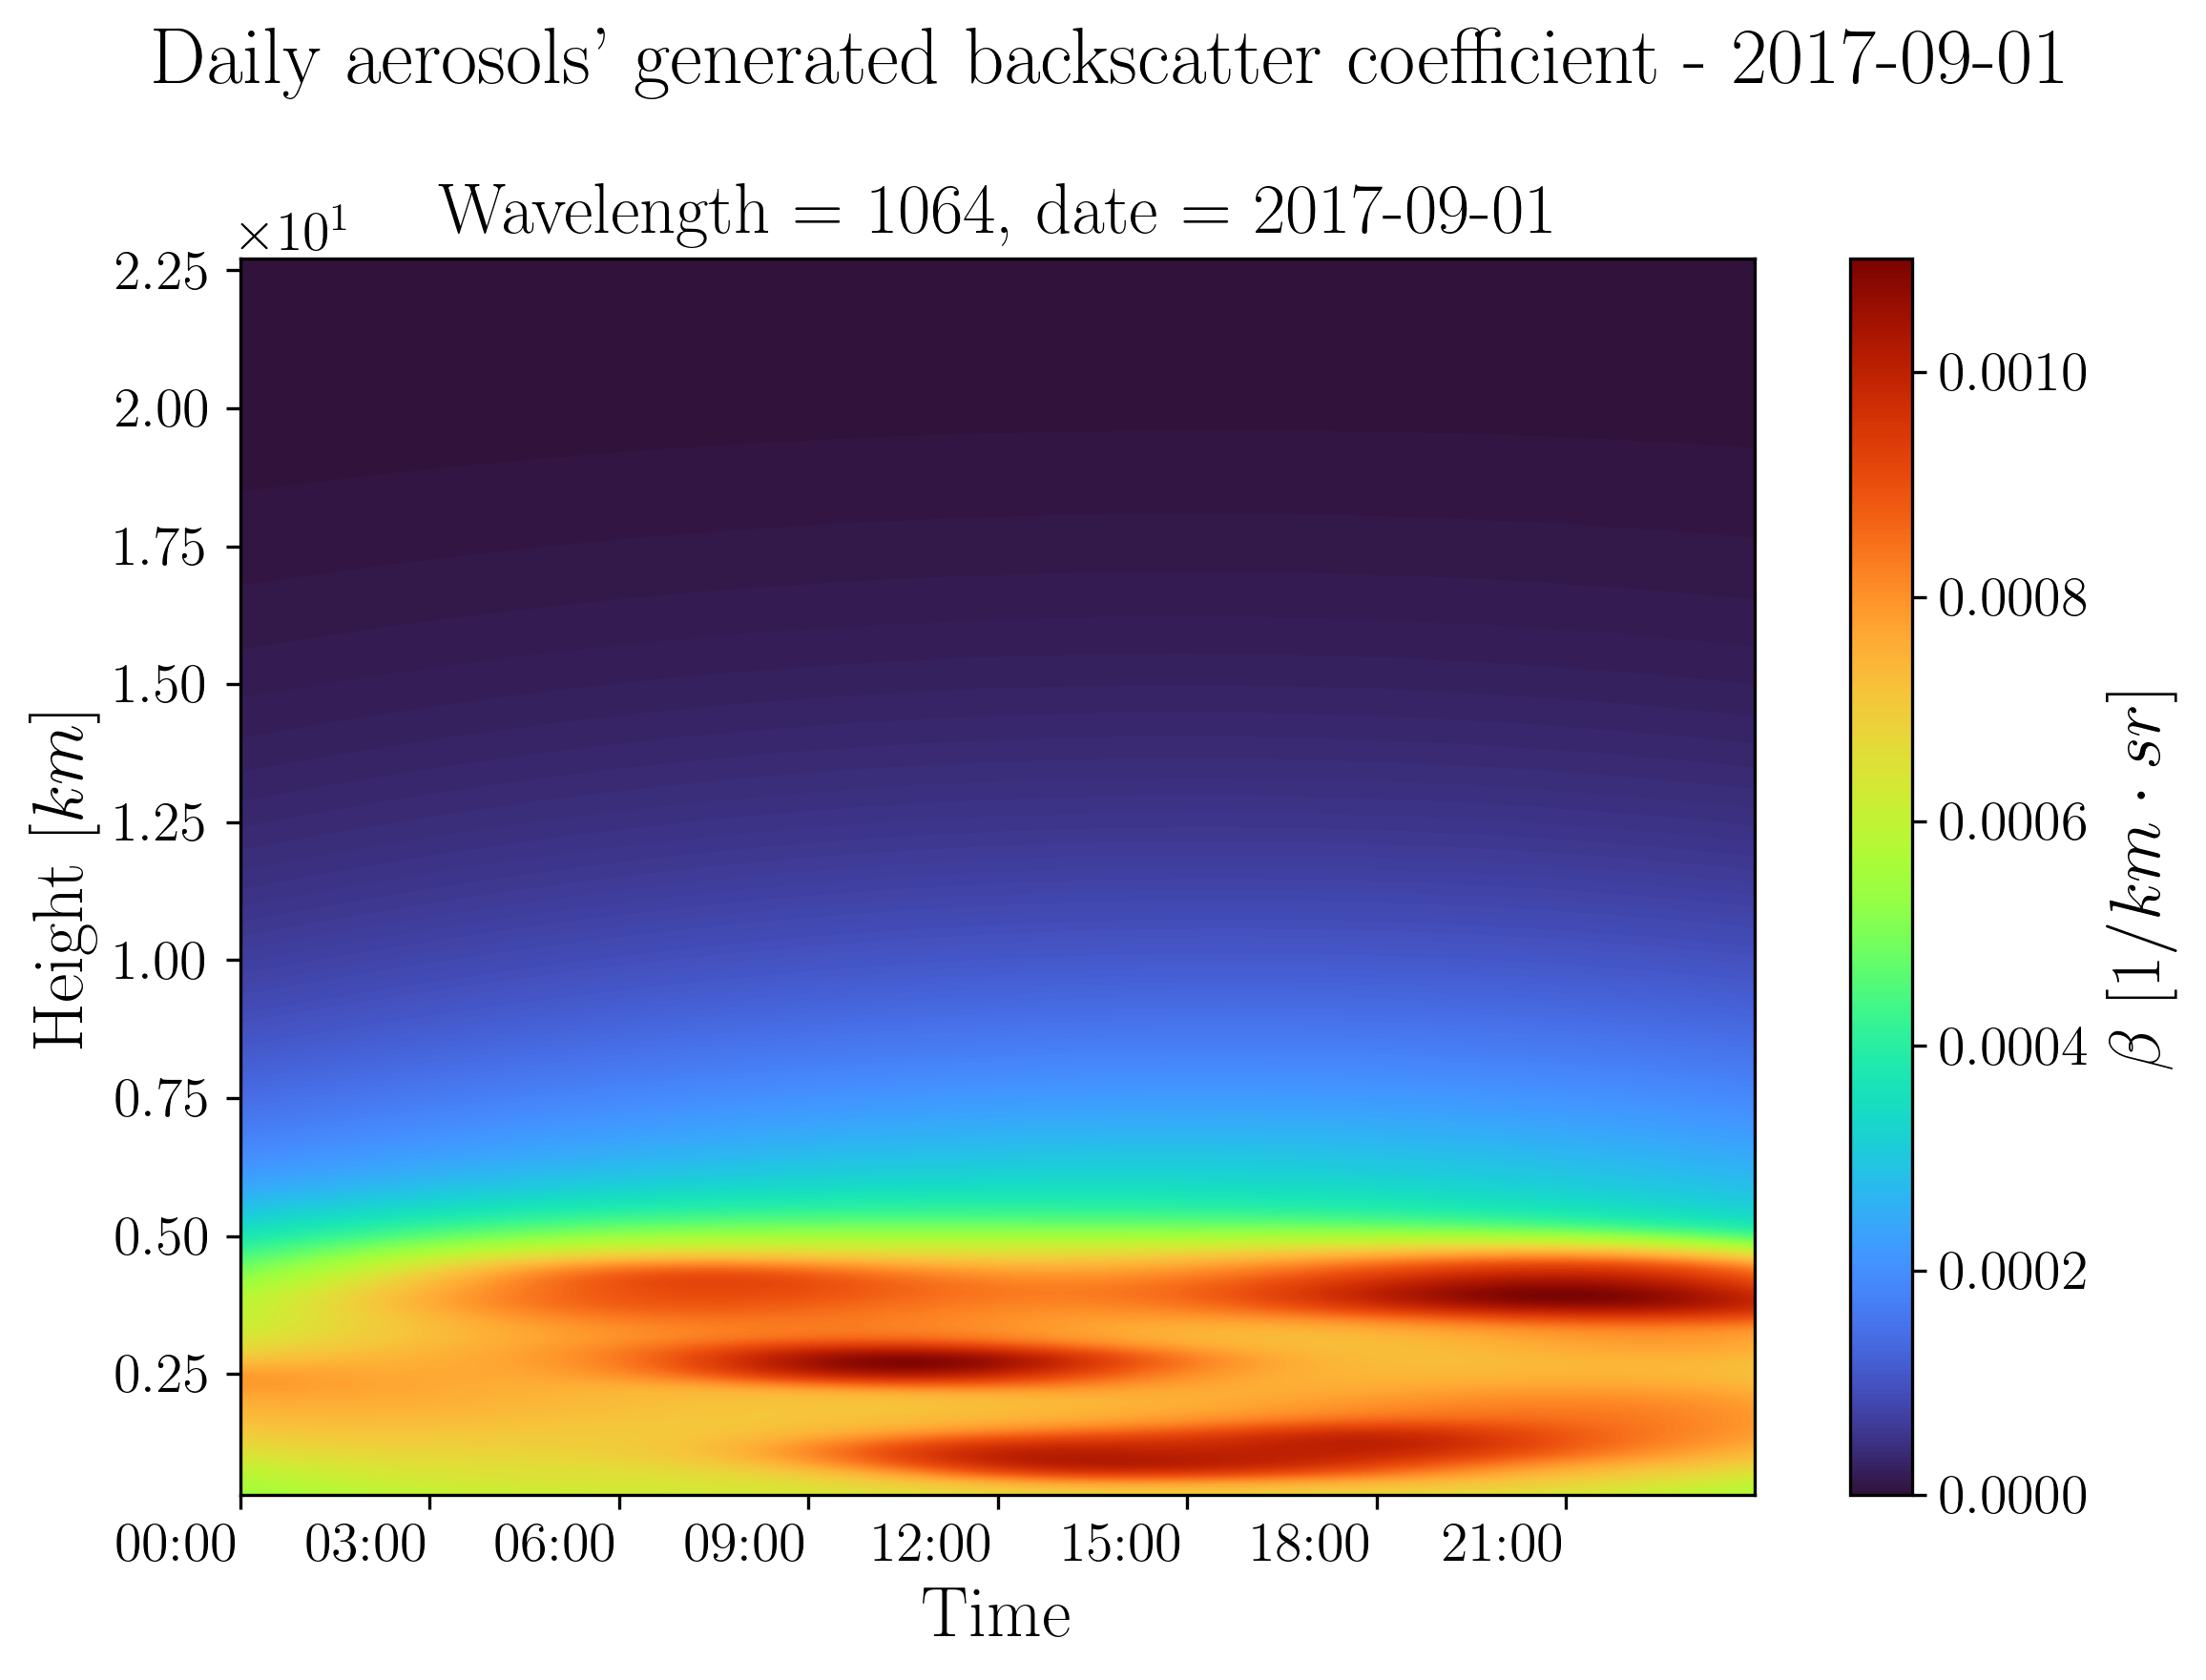

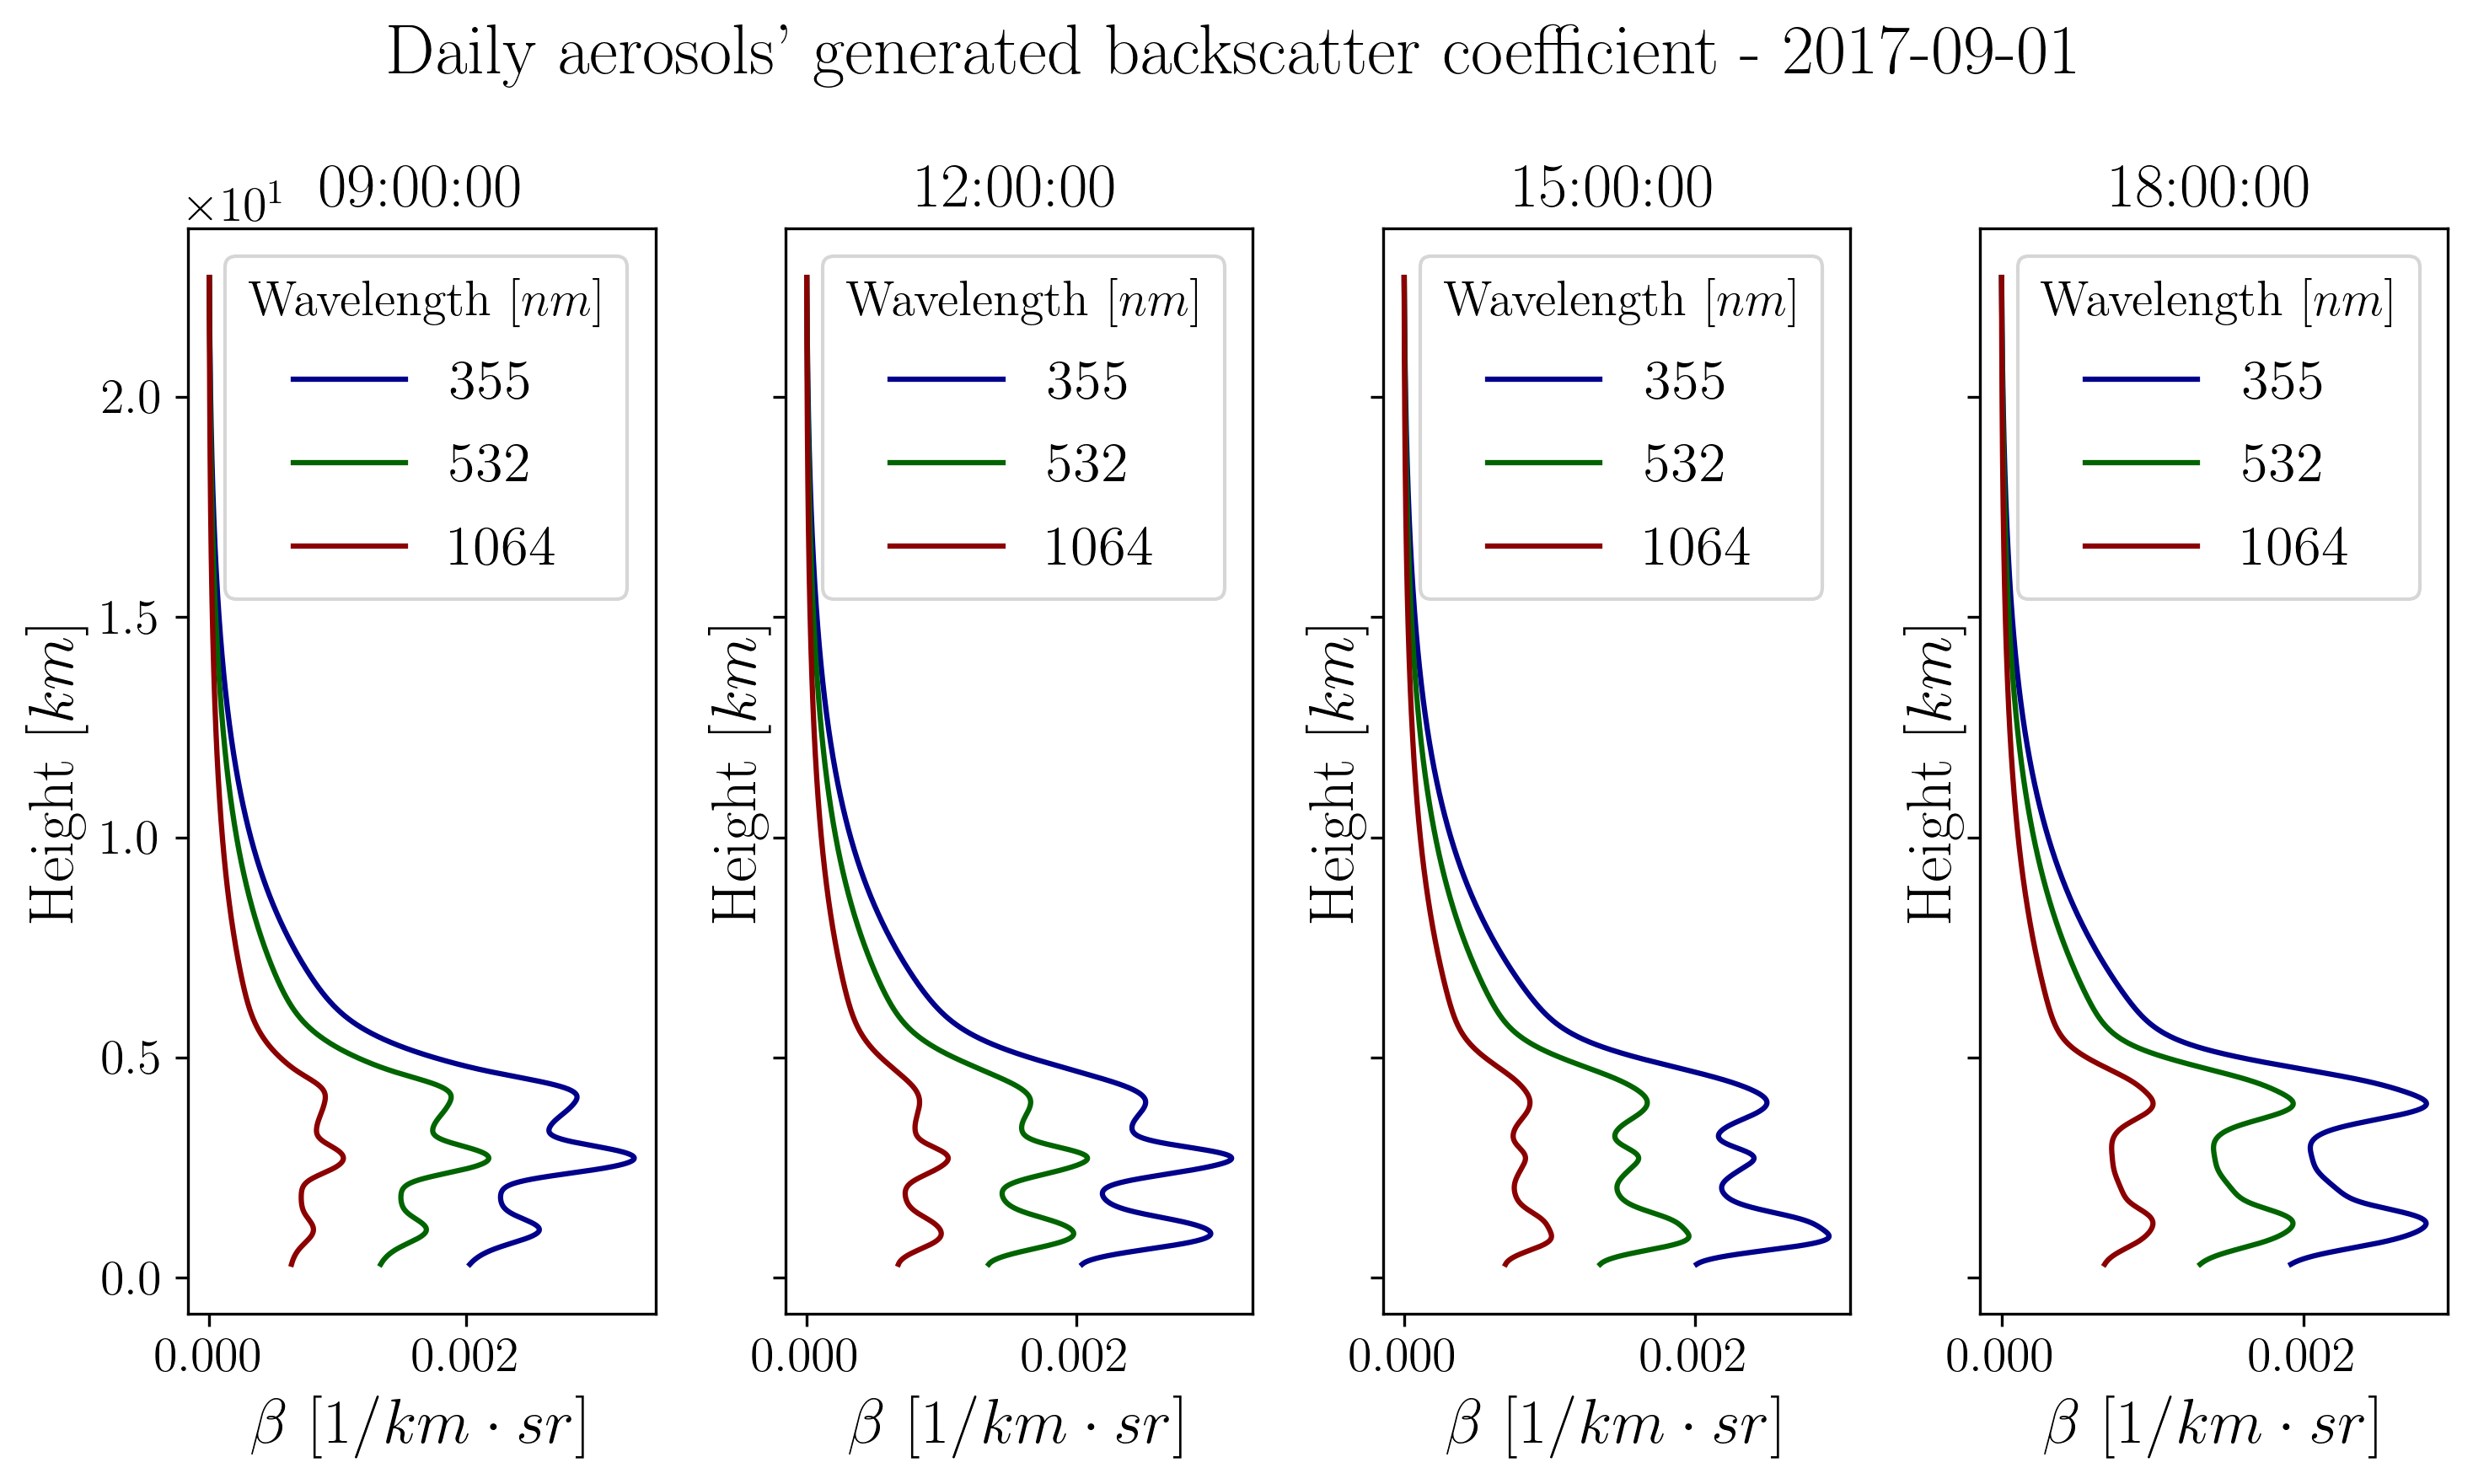

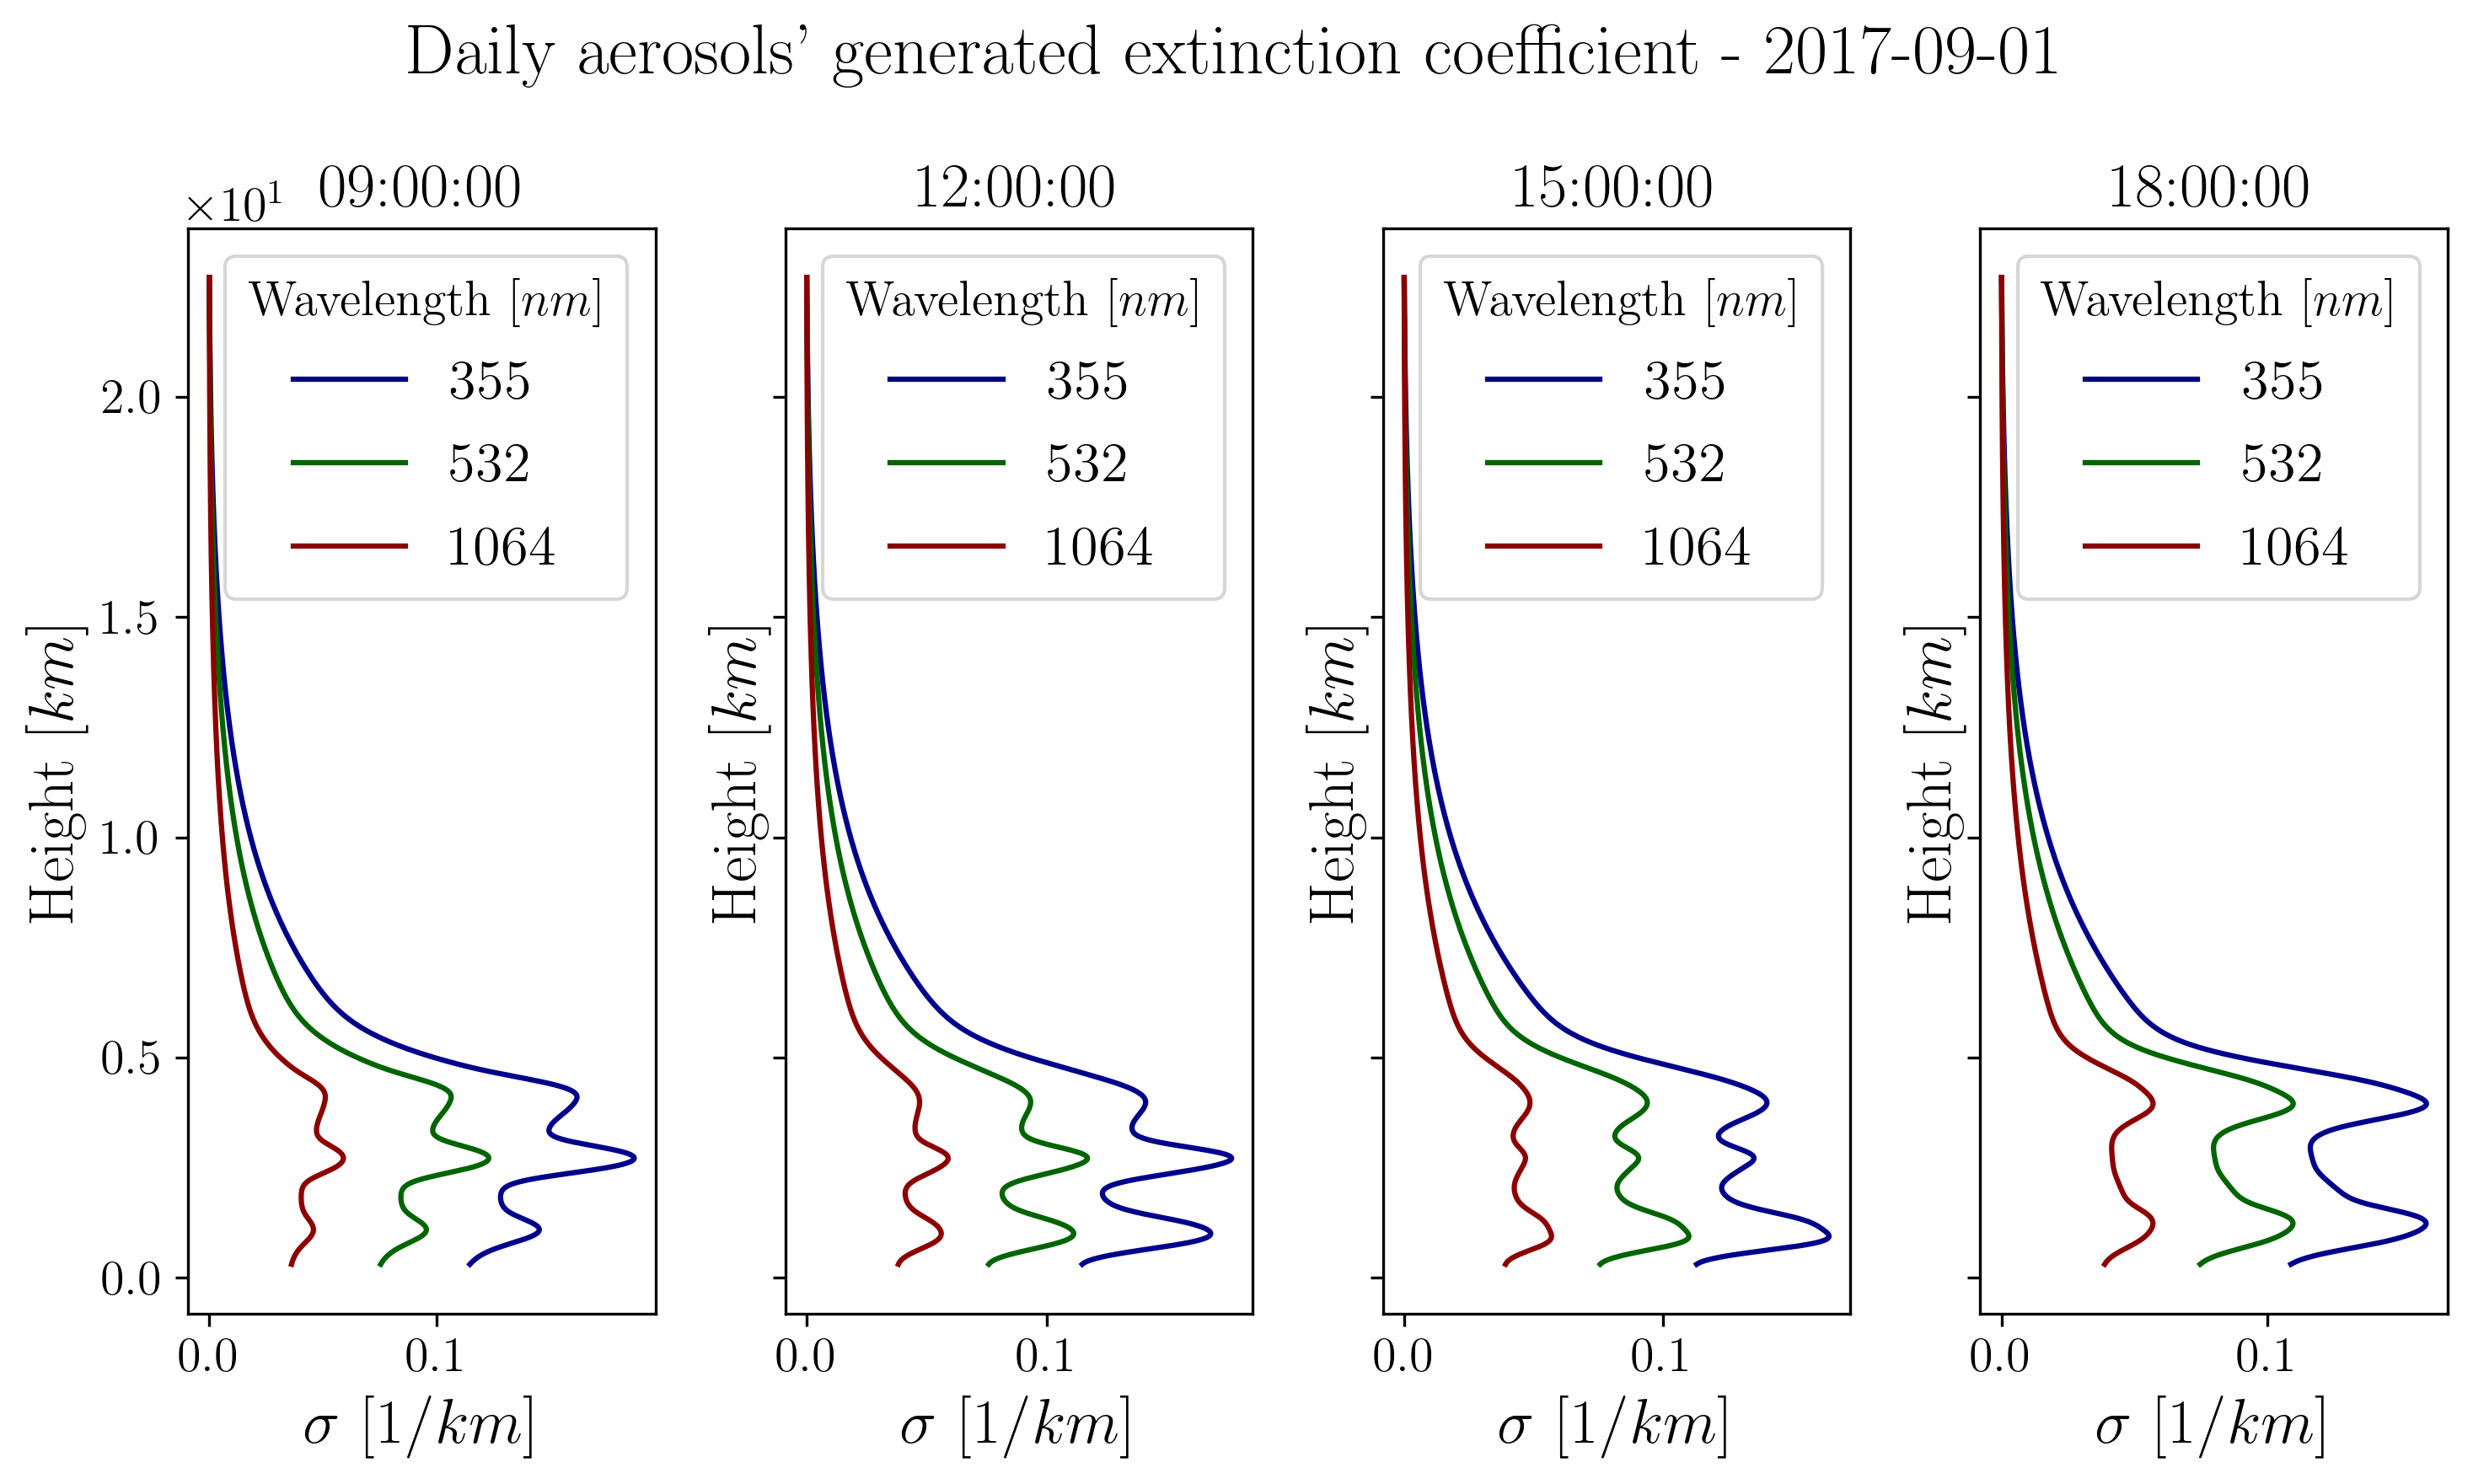

In [5]:
aerosol_folder = prep.get_month_folder_name(station.gen_aerosol_dataset,dt_day)
aerosols_nc_name = os.path.join(aerosol_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='aerosol'))
aerosol_ds = prep.load_dataset(aerosols_nc_name)
# %%
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(aerosol_ds.sigma.sel(Wavelength=wavelength), figsize=(8,6))

# %%
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(aerosol_ds.beta.sel(Wavelength=wavelength), figsize=(8,6))
# %%
gen_utils.plot_hourly_profile(aerosol_ds.beta,times=times)
gen_utils.plot_hourly_profile(aerosol_ds.sigma,times=times)

# 2. Background signal
# TODO: test transformers on bg_ds.bg and bg_r2

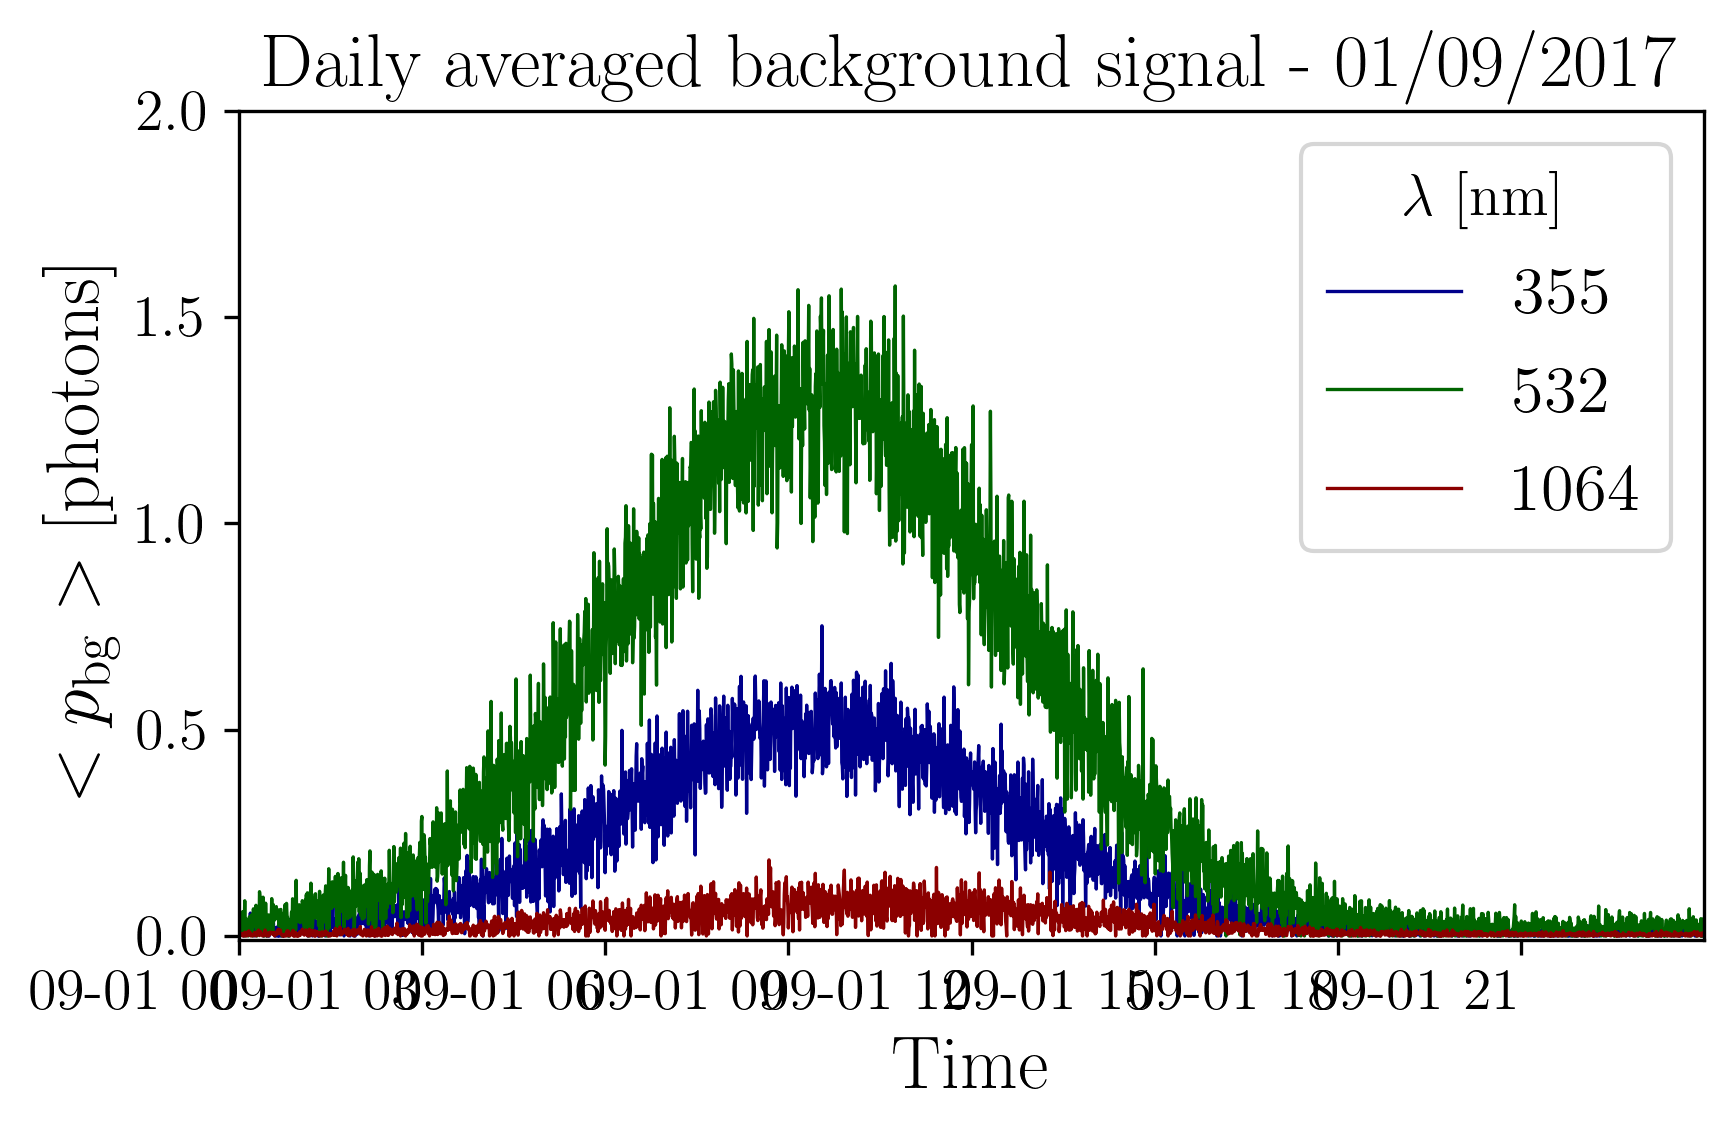

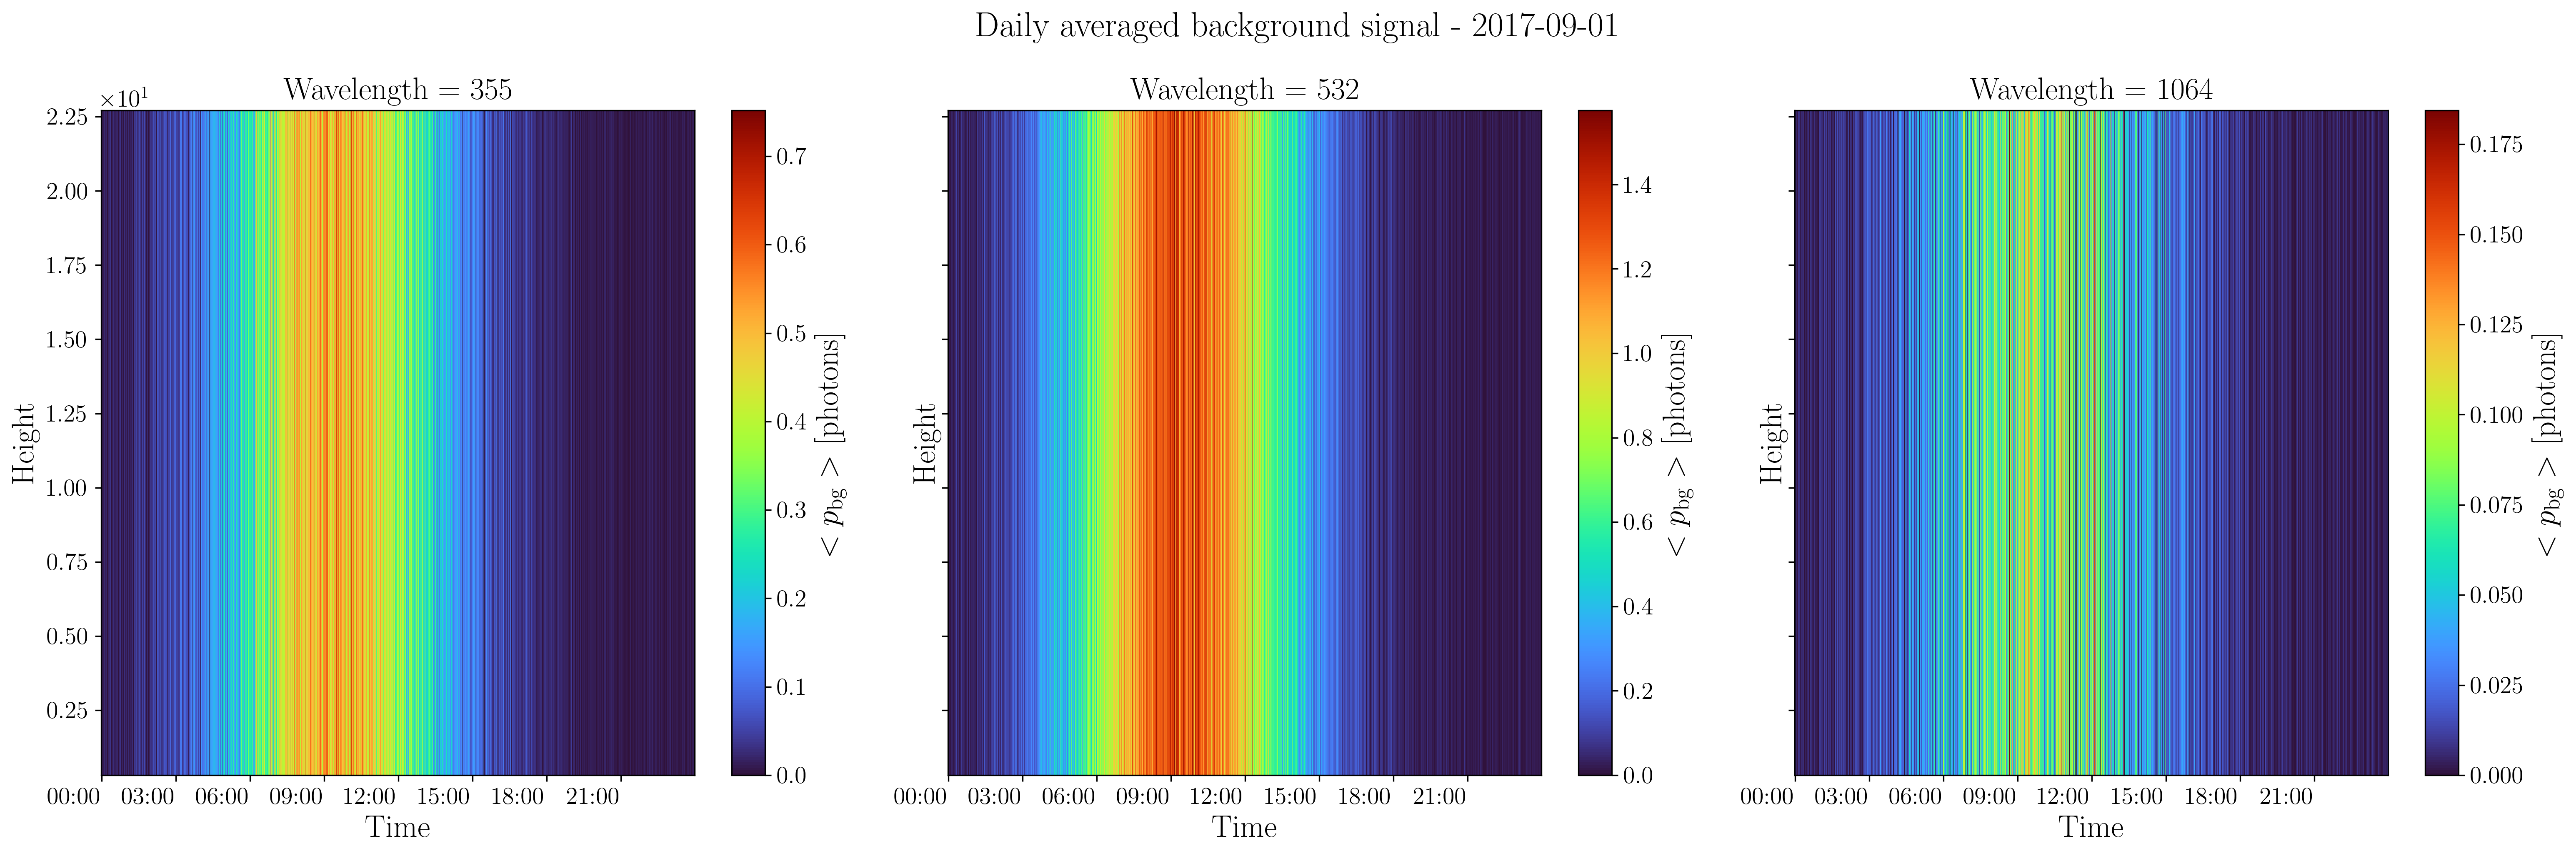

In [6]:
p_bg = get_daily_bg(station, dt_day)  # daily background: p_bg
# Expand p_bg to coordinates : 'Wavelength','Height', 'Time
bg_ds = p_bg.broadcast_like(r2_da).to_dataset()
bg_ds['date'] = dt_day
bg_ds.attrs['location'] = station.location

gen_utils.plot_daily_profile(bg_ds.bg, figsize=(21,7))

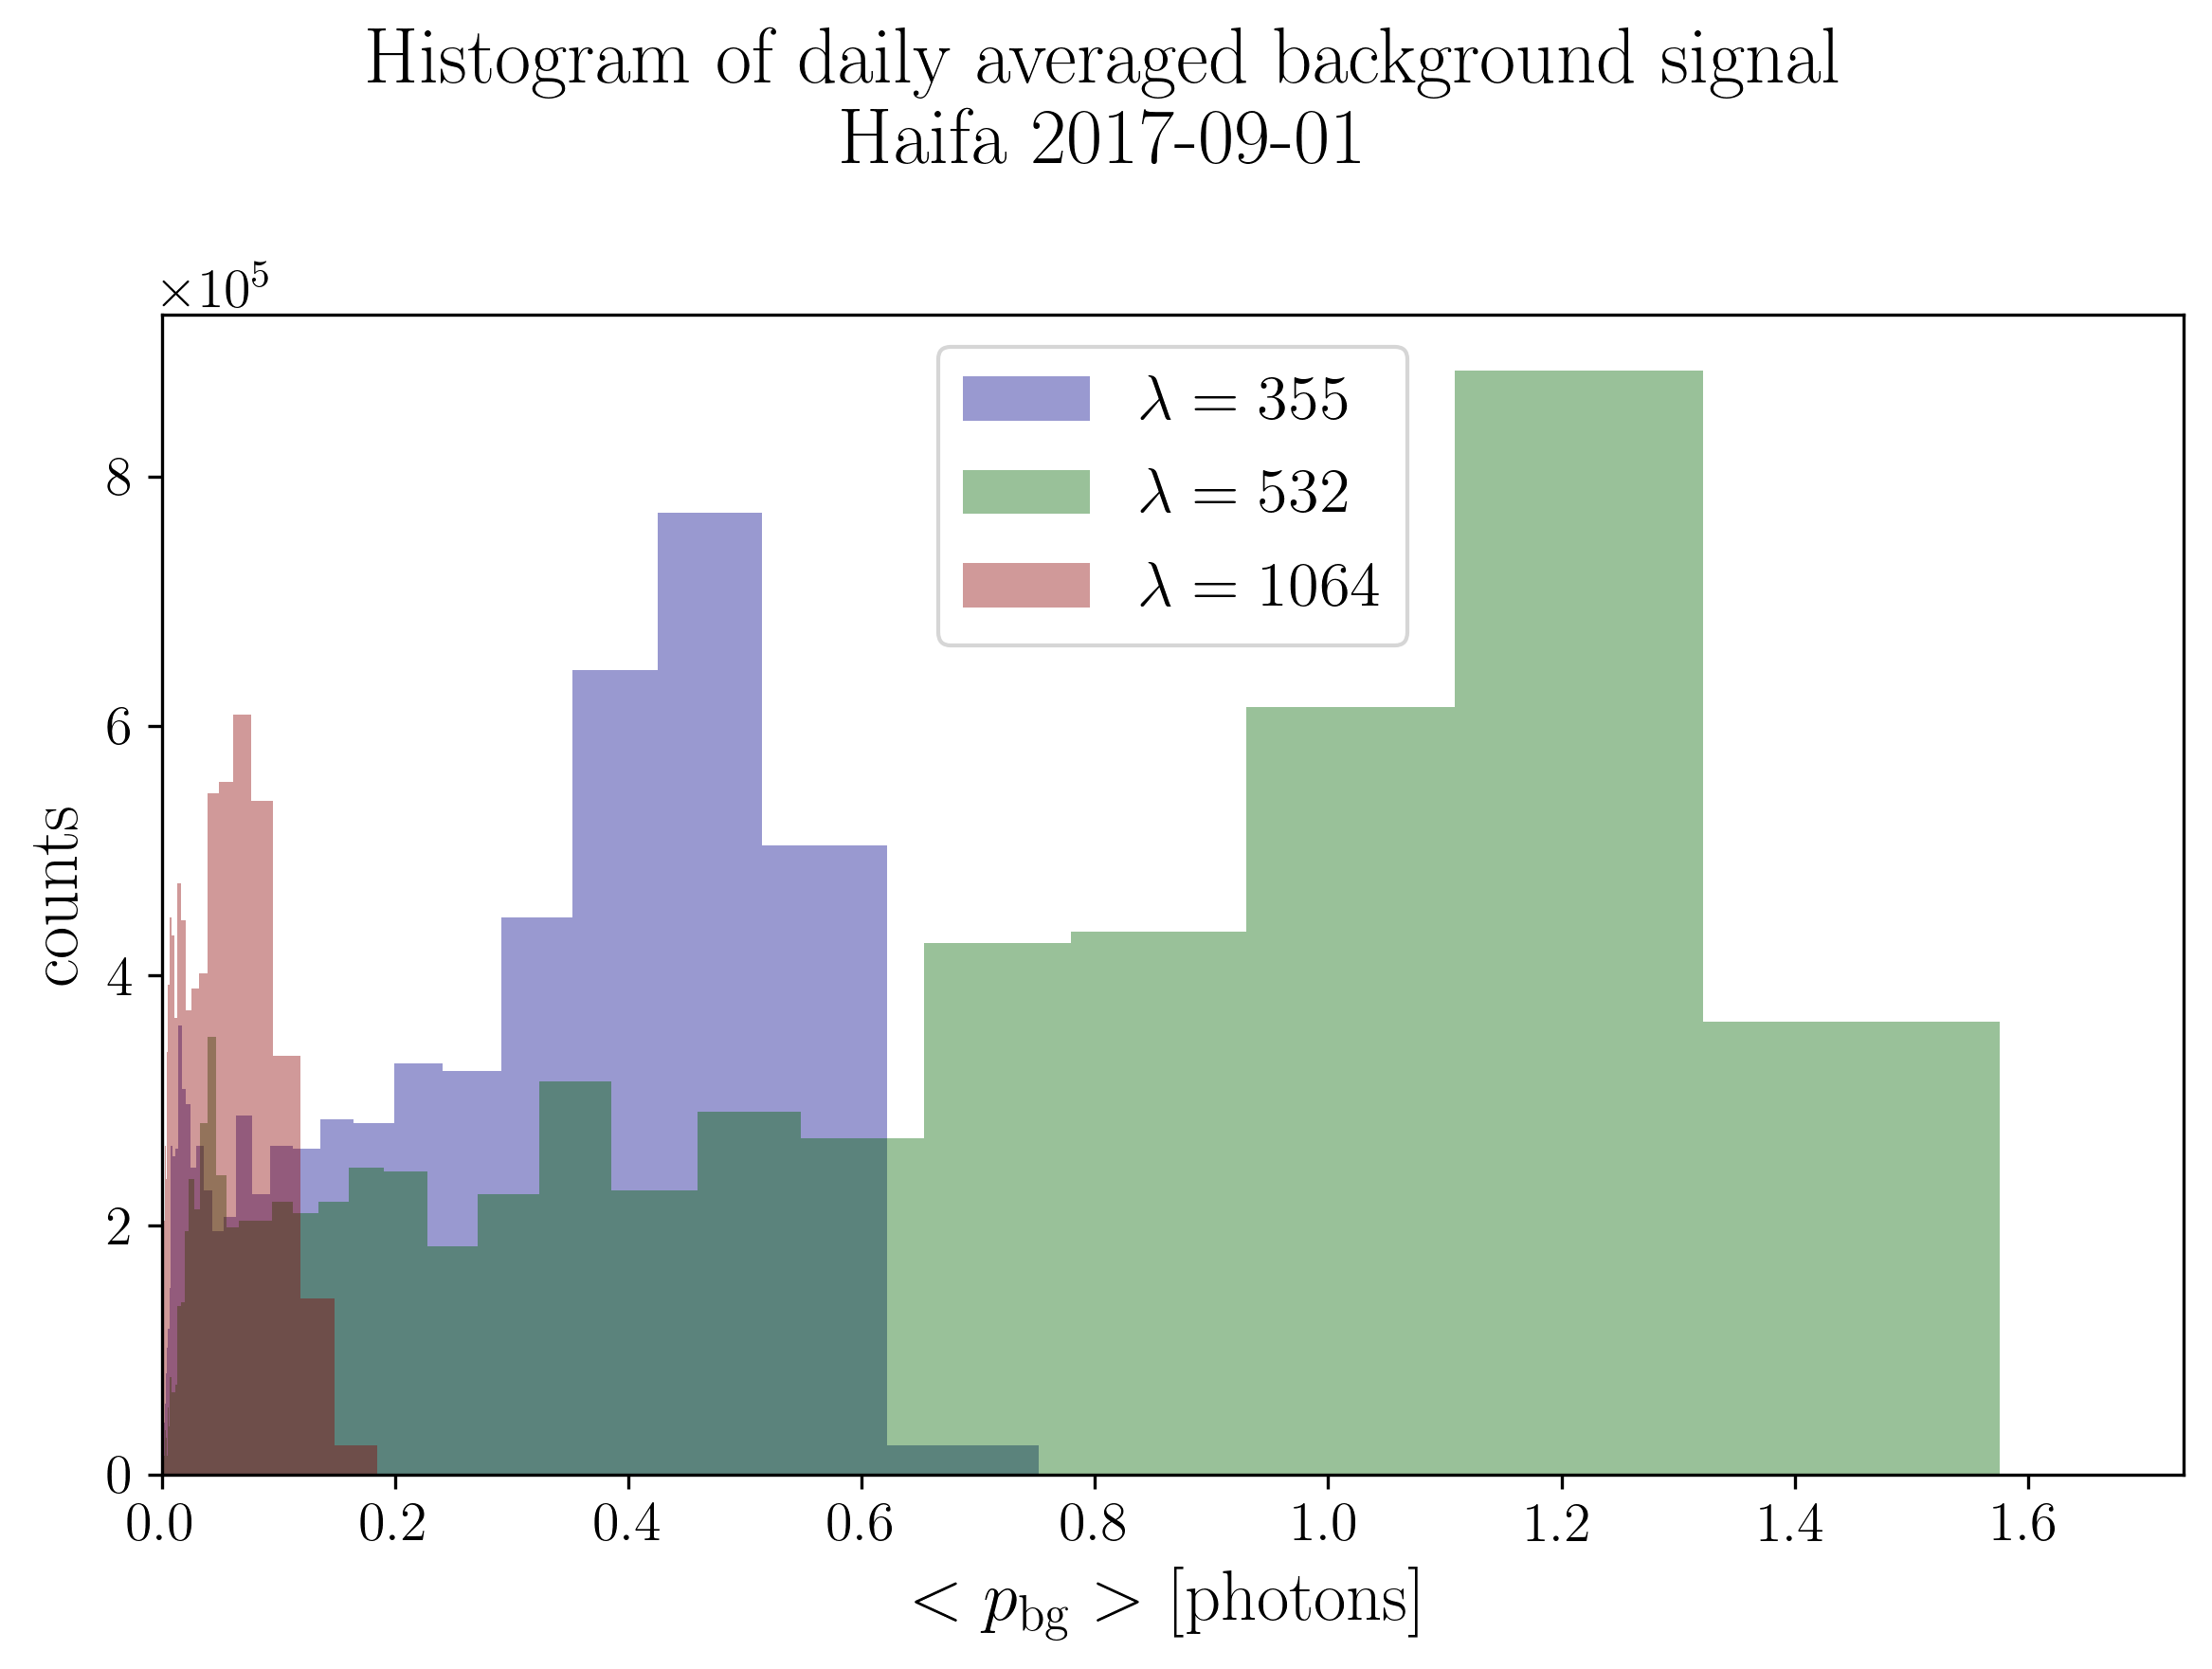

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,95.451389,0.0,4.548611,0.1710548,0.18464139
1,532,100.0,96.111111,0.0,3.888889,0.44045407,0.46370745
2,1064,100.0,92.500000,0.0,7.500000,0.030882165,0.03291483


In [7]:
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg',nbins=50)
bg_stats

In [8]:
gamma_bg = 0.25
bg_pow = xr.apply_ufunc(lambda x: x**gamma_bg, bg_ds.bg ,keep_attrs=True)
# %%
bg_pow = bg_pow.assign_attrs({'info':bg_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_bg}$'})
bg_ds = bg_ds.assign(bgpow= bg_pow)

# %%
_,_,bg_pow_stats= daily_ds_histogram(bg_ds, profile_type='bgpow',nbins=150)
bg_pow_stats

NameError: name 'gamma_mol' is not defined

In [12]:
bg_r2 =  bg_ds.bg*signal_ds.r2
bg_r2

<xarray.DataArray (Wavelength: 3, Height: 3000, Time: 2880)>
array([[[8.11678983e-05, 9.95126684e-05, 1.37702349e-18, ...,
         2.92487039e-06, 1.07847227e-04, 6.26144756e-05],
        [9.73002461e-05, 1.19291086e-04, 1.65071077e-18, ...,
         3.50619666e-06, 1.29282169e-04, 7.50592735e-05],
        [1.14893839e-04, 1.40861011e-04, 1.94918825e-18, ...,
         4.14017859e-06, 1.52658642e-04, 8.86313064e-05],
        ...,
        [6.60871553e+00, 8.10235214e+00, 1.12117679e-13, ...,
         2.38143861e-01, 8.78095436e+00, 5.09808969e+00],
        [6.61311102e+00, 8.10774136e+00, 1.12192251e-13, ...,
         2.38302261e-01, 8.78679466e+00, 5.10148048e+00],
        [6.61750793e+00, 8.11313152e+00, 1.12266845e-13, ...,
         2.38460690e-01, 8.79263687e+00, 5.10487223e+00]],

       [[1.97685382e-04, 2.34692459e-04, 3.56986944e-04, ...,
         1.37702349e-18, 2.48468514e-05, 2.57039006e-04],
        [2.36975902e-04, 2.81338231e-04, 4.27939085e-04, ...,
         1.65071077e-18, 2.97852330e-05, 3.08126211e-04],
        [2.79825297e-04, 3.32209136e-04, 5.05317992e-04, ...,
         1.94918825e-18, 3.51709241e-05, 3.63840838e-04],
...
        [1.60956059e+01, 1.91087322e+01, 2.90659866e+01, ...,
         1.12117679e-13, 2.02303839e+00, 2.09281940e+01],
        [1.61063099e+01, 1.91214428e+01, 2.90853195e+01, ...,
         1.12192251e-13, 2.02438378e+00, 2.09421139e+01],
        [1.61170197e+01, 1.91341553e+01, 2.91046581e+01, ...,
         1.12266845e-13, 2.02572989e+00, 2.09560375e+01]],

       [[5.21914008e-05, 6.30296054e-05, 1.89851617e-05, ...,
         5.02654802e-05, 1.07342594e-05, 2.20804341e-05],
        [6.25645916e-05, 7.55569199e-05, 2.27585151e-05, ...,
         6.02558866e-05, 1.28677239e-05, 2.64689843e-05],
        [7.38773670e-05, 8.92189346e-05, 2.68736549e-05, ...,
         7.11512039e-05, 1.51944341e-05, 3.12550401e-05],
        ...,
        [4.24944019e+00, 5.13189030e+00, 1.54577780e+00, ...,
         4.09263086e+00, 8.73986721e-01, 1.79779589e+00],
        [4.25226641e+00, 5.13530350e+00, 1.54680586e+00, ...,
         4.09535313e+00, 8.74568045e-01, 1.79899156e+00],
        [4.25509357e+00, 5.13871813e+00, 1.54783428e+00, ...,
         4.09807587e+00, 8.75149488e-01, 1.80018771e+00]]], dtype=float32)
Coordinates:
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
  * Wavelength  (Wavelength) int32 355 532 1064
  * Height      (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
    date        datetime64[ns] 2017-09-01

# 3. Clean Lidar Signal

In [9]:
signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,dt_day)
signal_nc_name = os.path.join(signal_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='signal'))
signal_ds = prep.load_dataset(signal_nc_name)

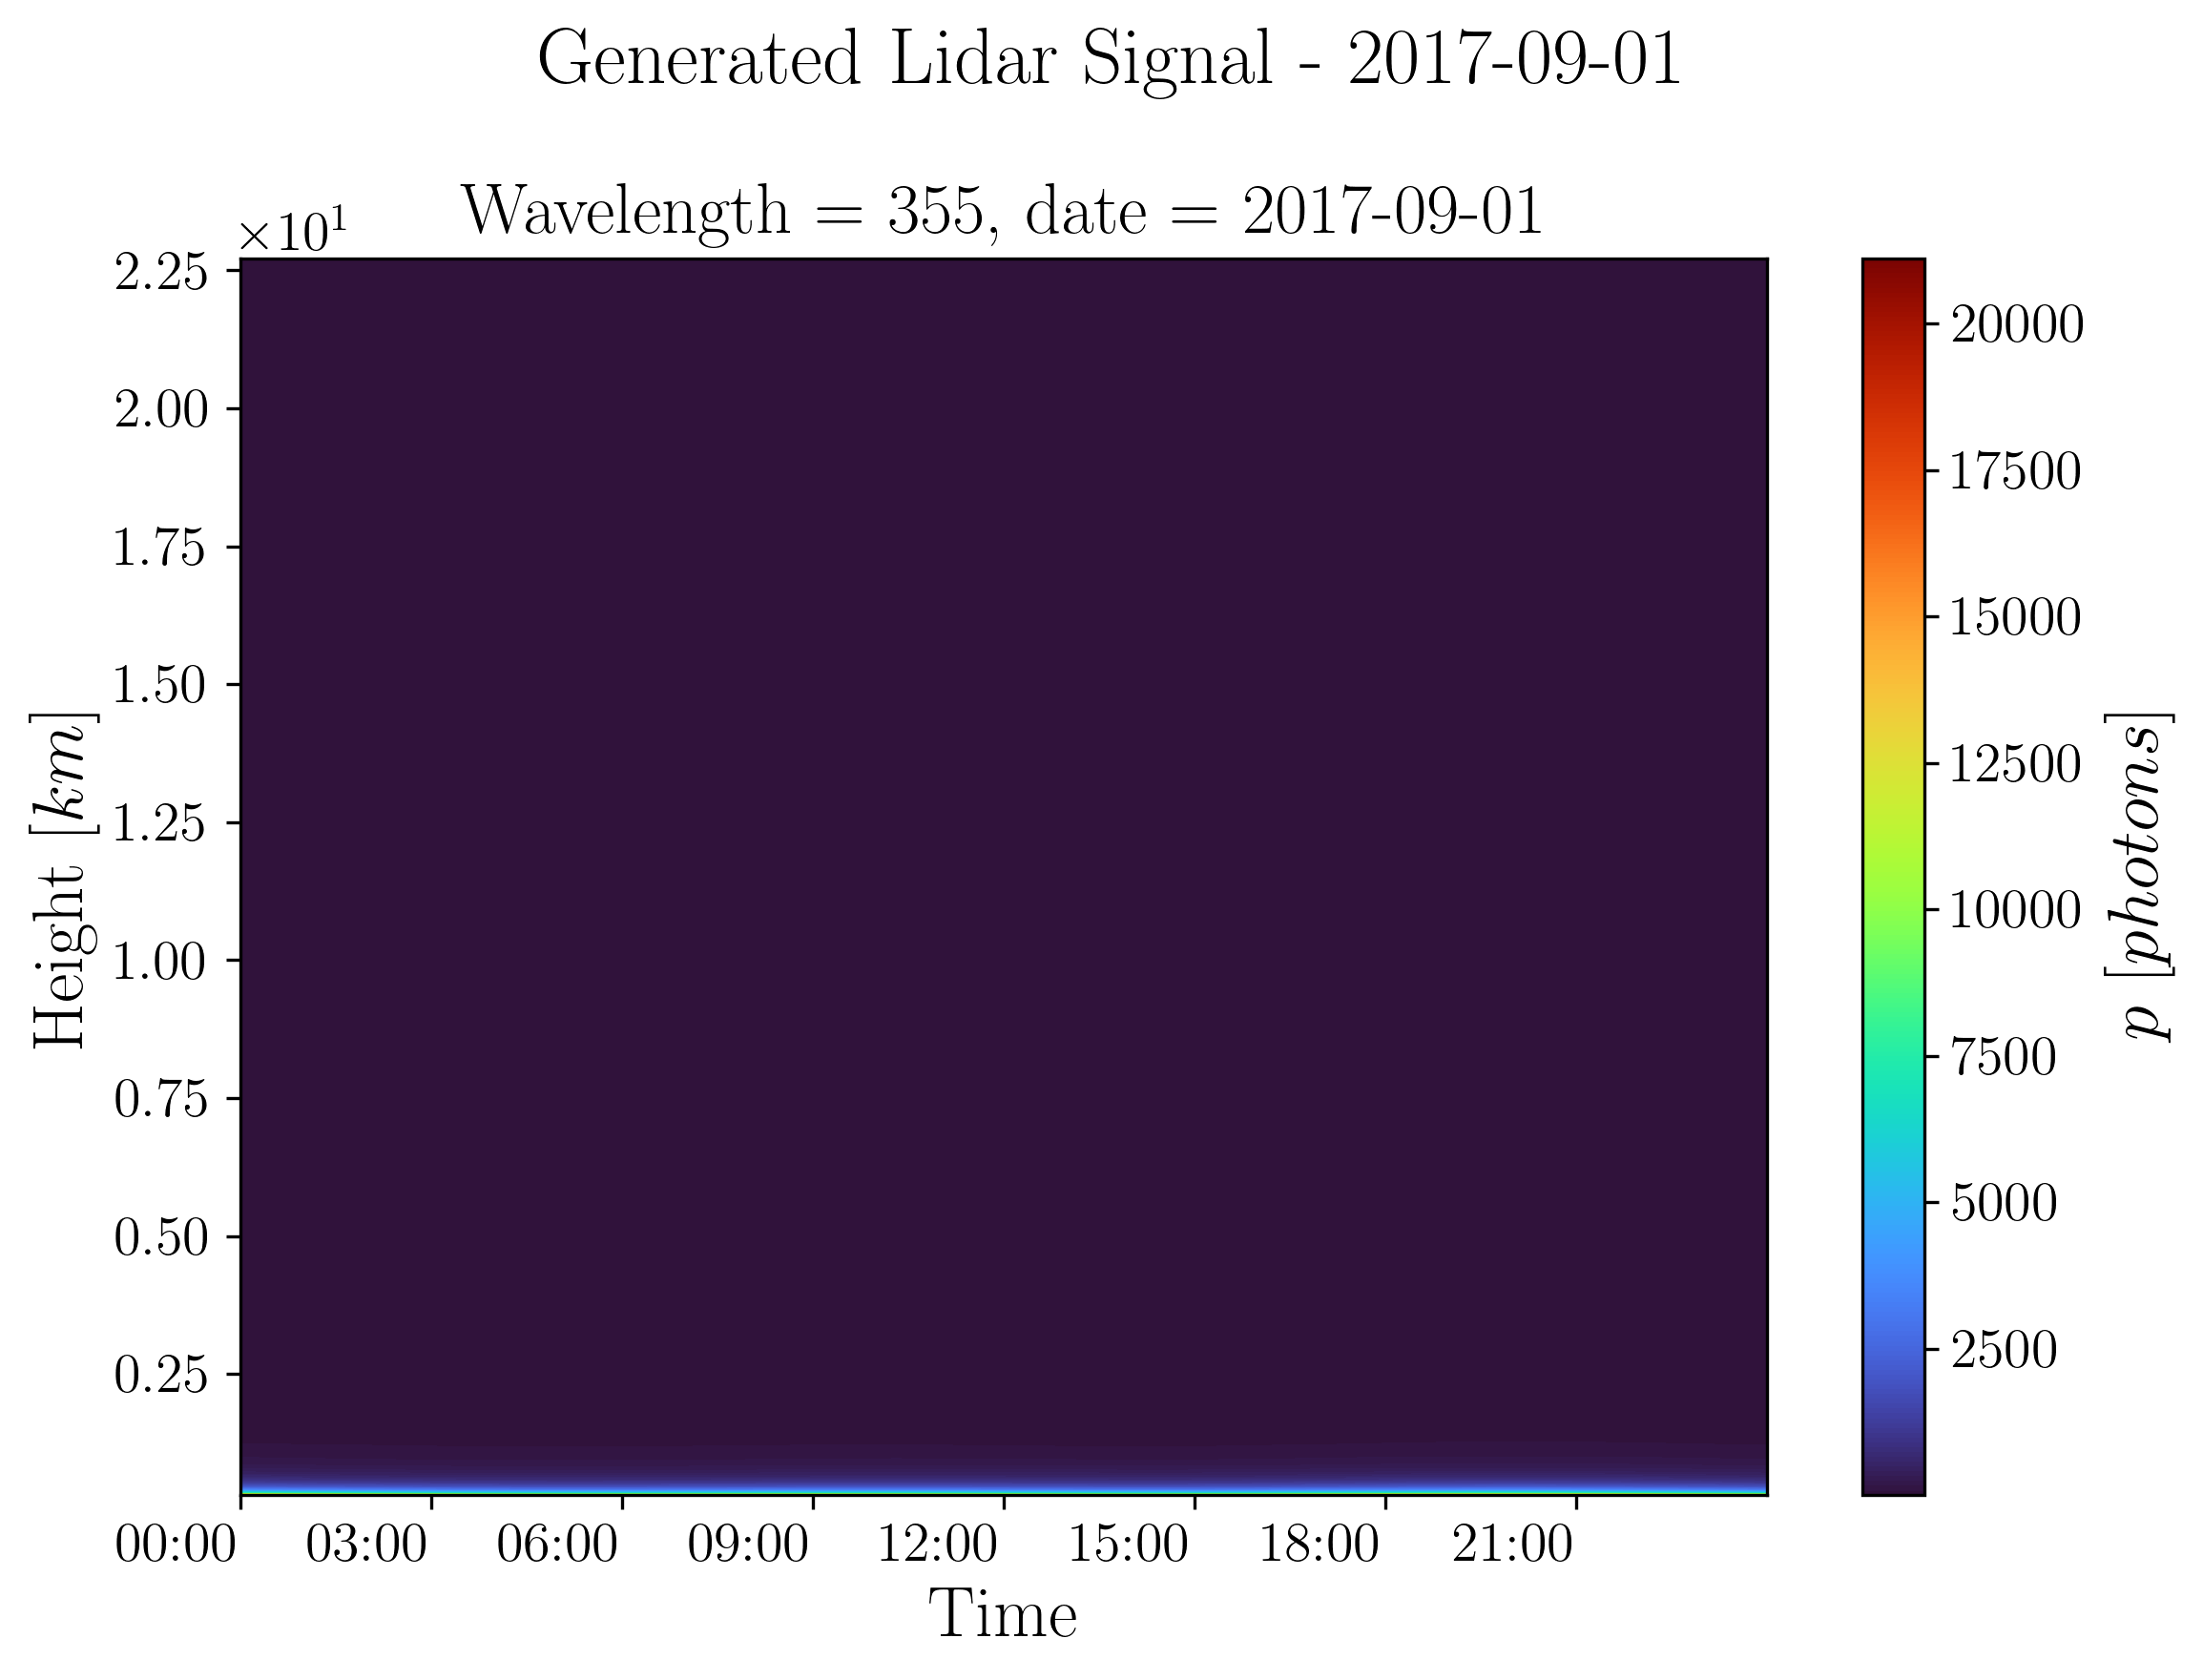

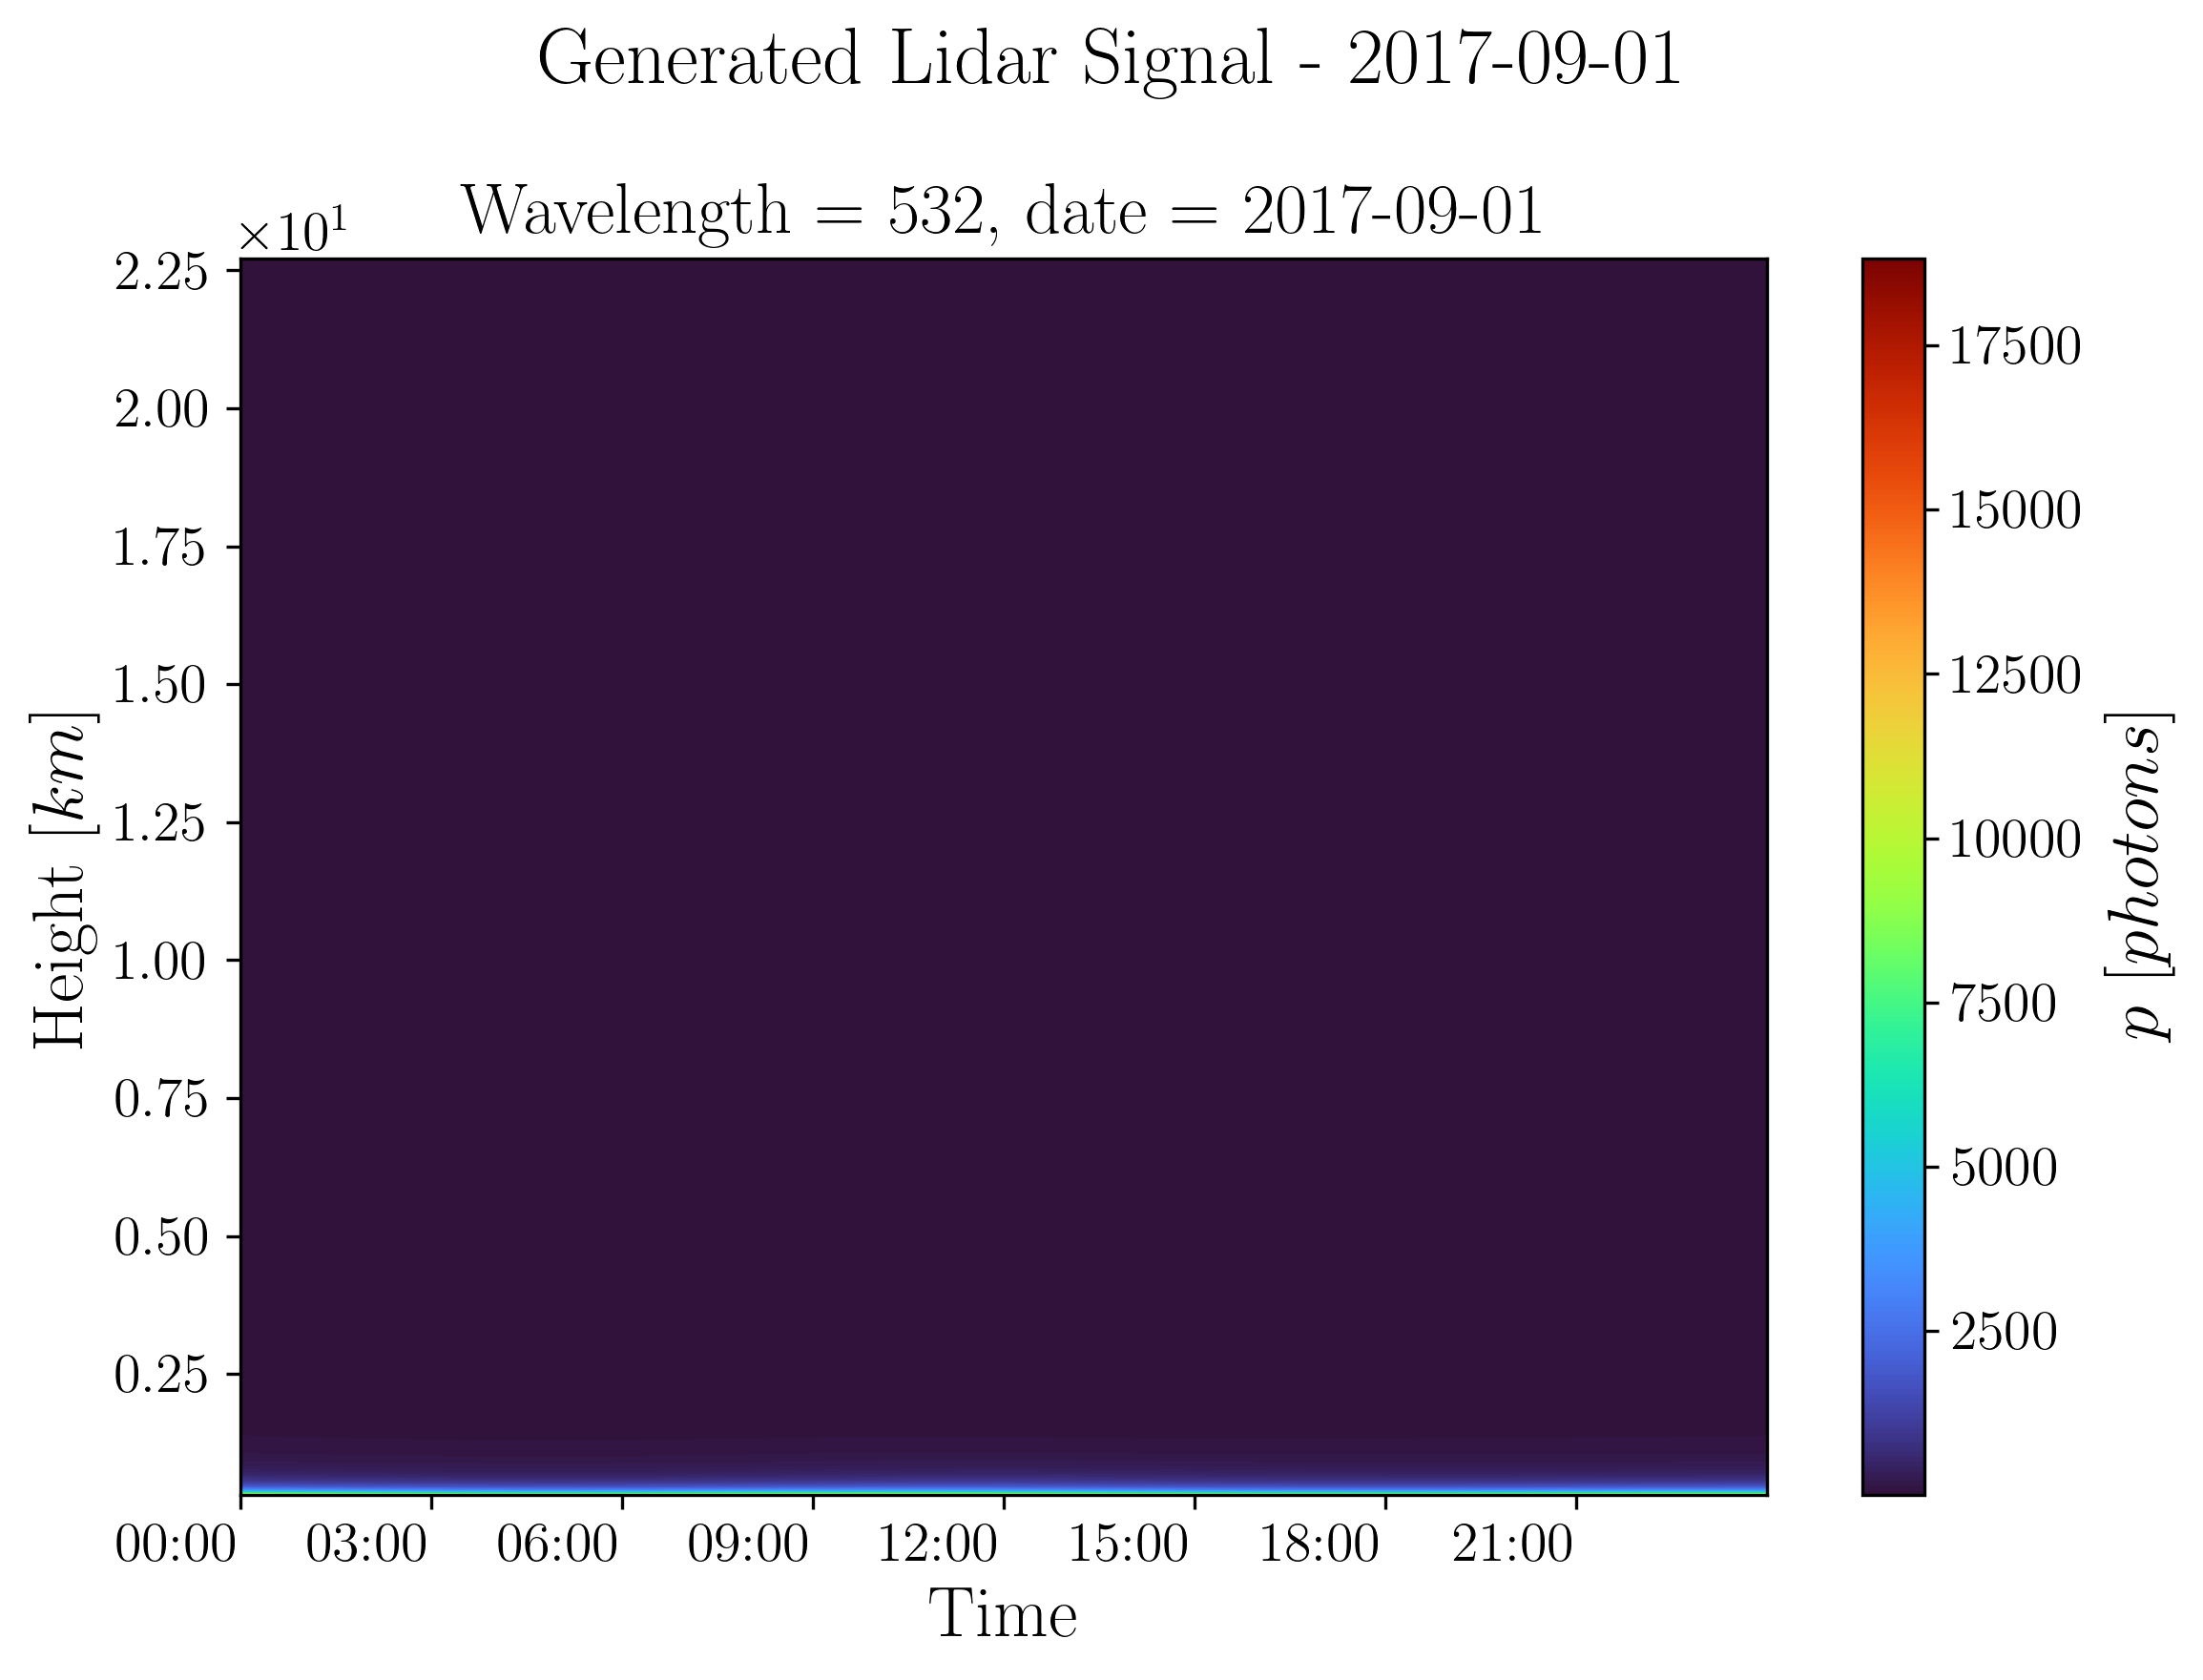

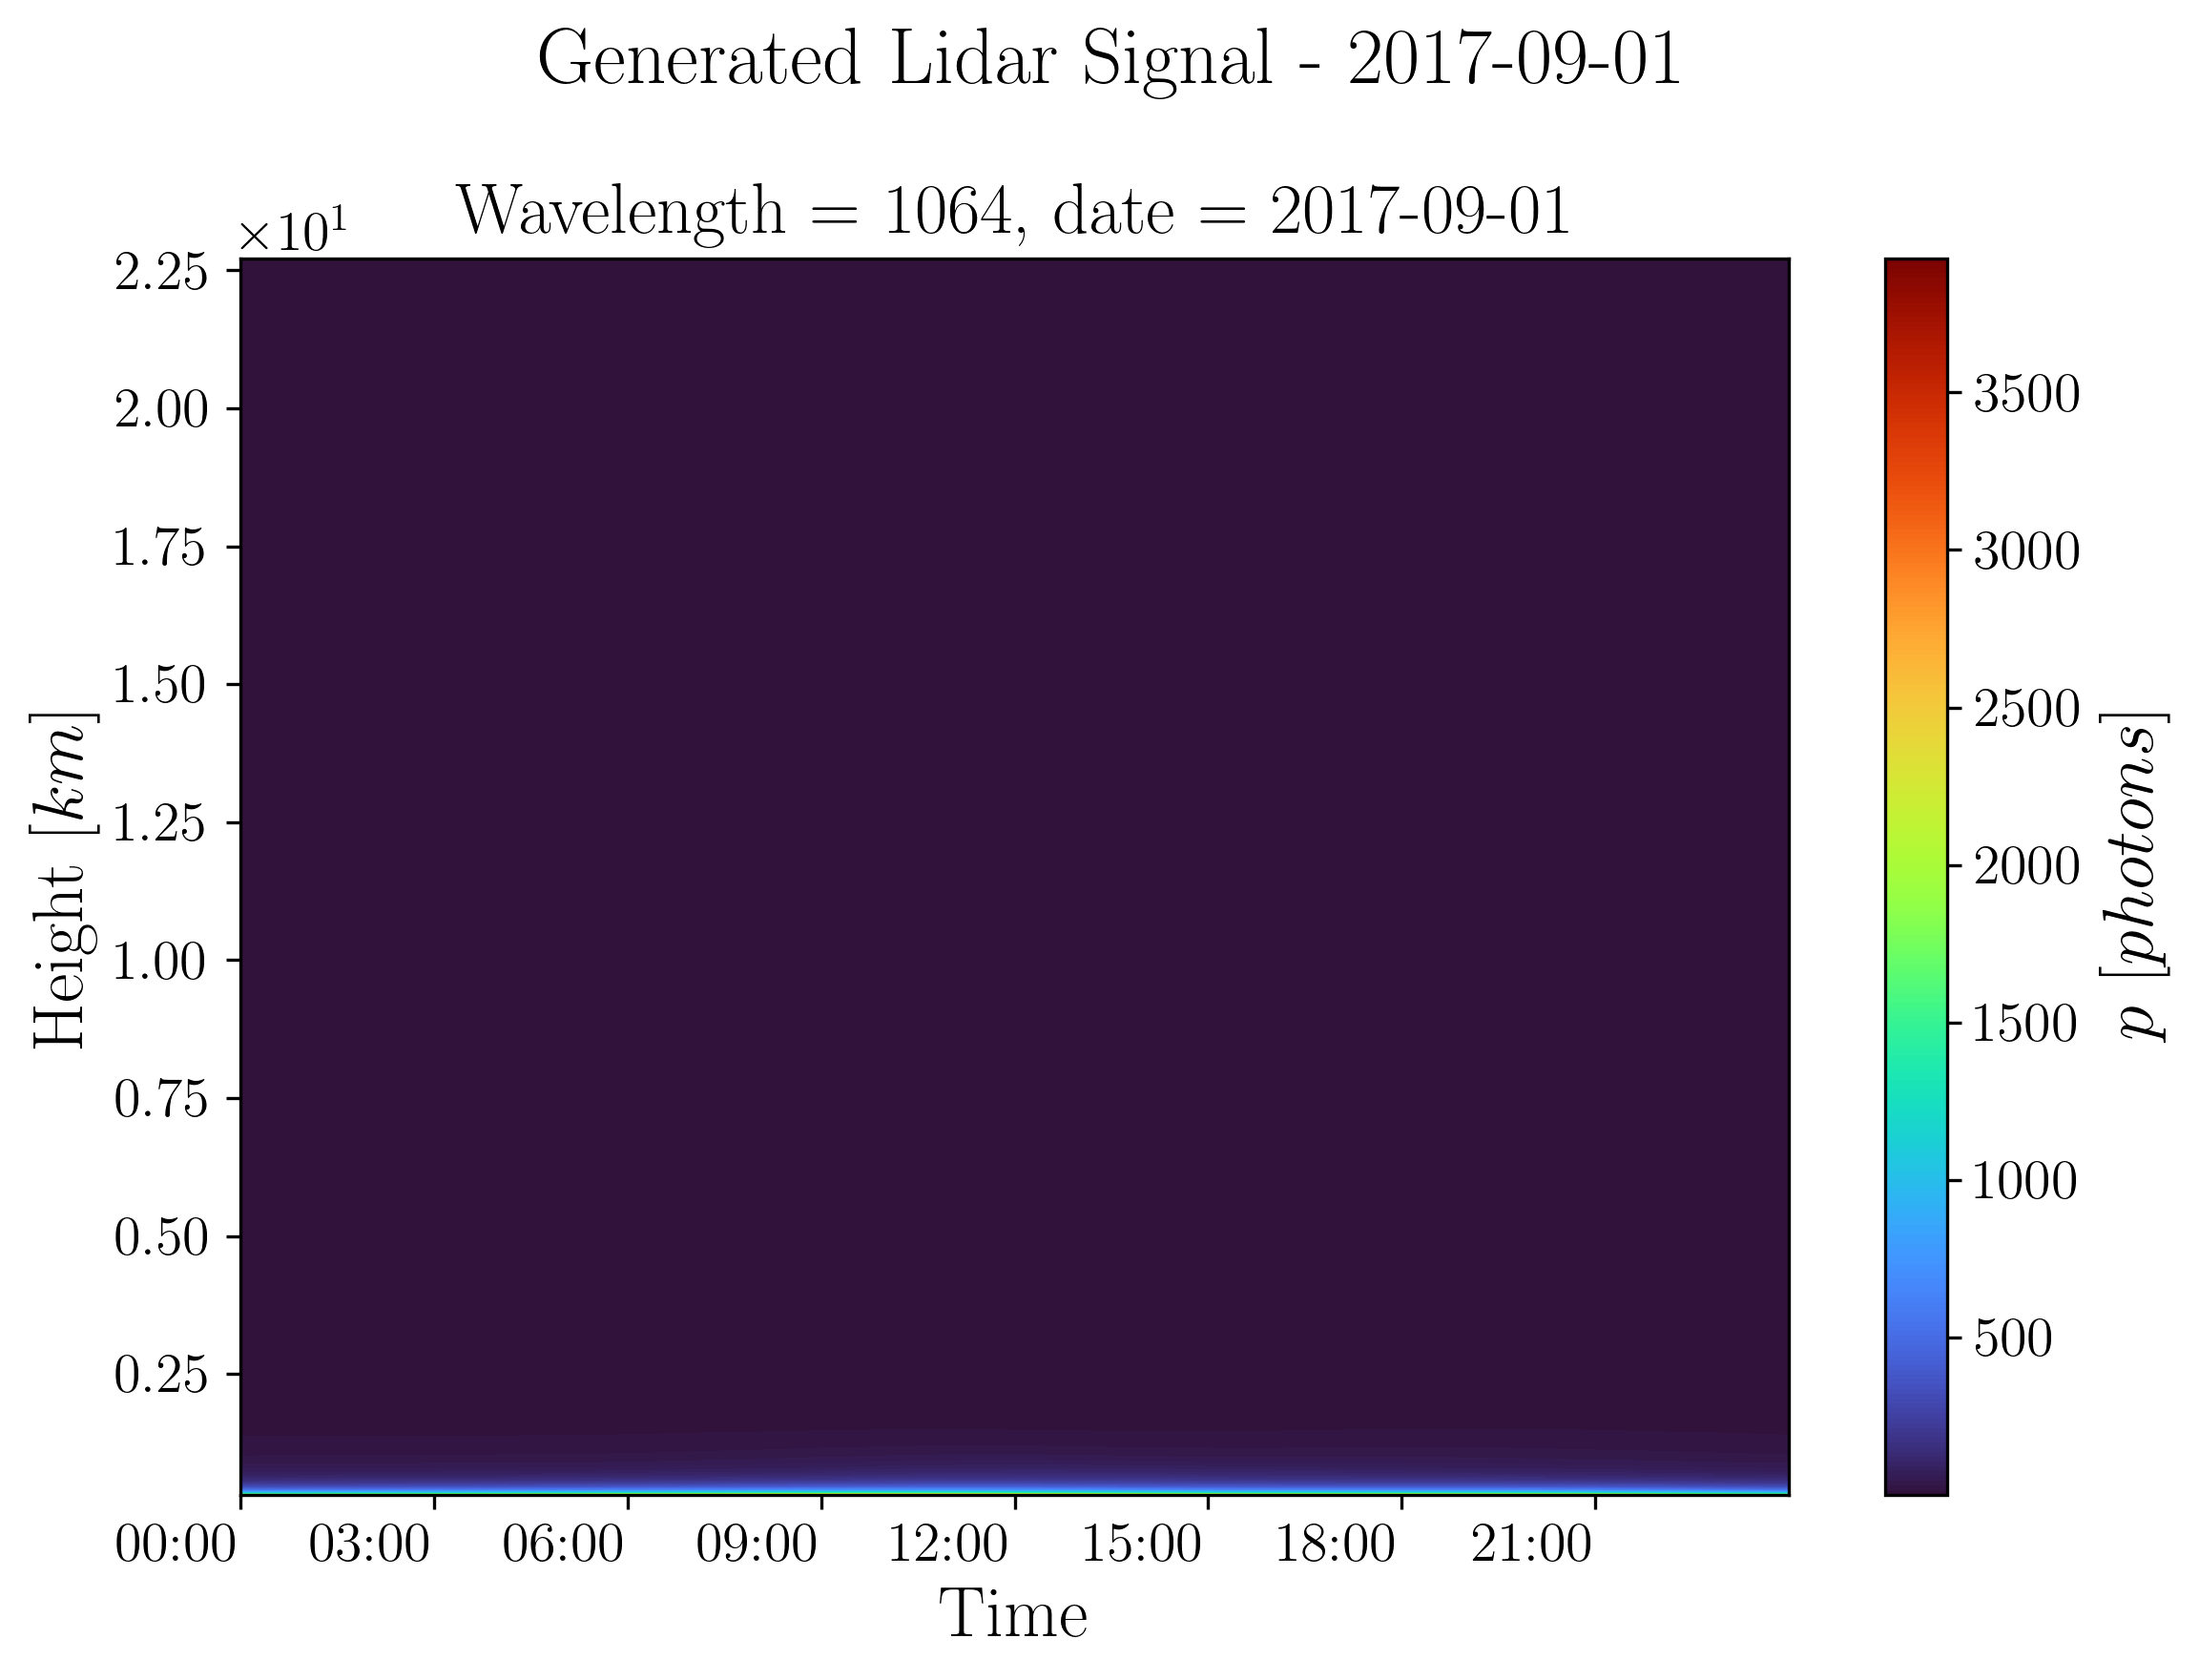

In [10]:
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(signal_ds.p.sel(Wavelength=wavelength), figsize=(8,6))

In [ ]:
_,_,p_stats= daily_ds_histogram(signal_ds, profile_type='p')#,log_scale=True)
p_stats

In [ ]:
gamma_p = 0.01
p_pow = xr.apply_ufunc(lambda x: x**gamma_p, signal_ds.p ,keep_attrs=True)
# %%
p_pow = p_pow.assign_attrs({'info':p_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_p}$'})
signal_ds = signal_ds.assign(ppow= p_pow)

# %%
_,_,p_pow_stats= daily_ds_histogram(signal_ds, profile_type='ppow',nbins=50)
p_pow_stats

# 4. Total attbsc

In [ ]:
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(signal_ds.attbsc.sel(Wavelength=wavelength), figsize=(8,6))

In [ ]:
gen_utils.plot_hourly_profile(signal_ds.attbsc,figsize=(8,6))

# 4. Lidar measurement
# TODO: test transformers on lidar_ds.p

In [ ]:
lidar_folder = prep.get_month_folder_name(station.gen_lidar_dataset,dt_day)
lidar_nc_name = os.path.join(lidar_folder,gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='lidar'))
lidar_ds = prep.load_dataset(lidar_nc_name)
# %%
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(lidar_ds.p.sel(Wavelength=wavelength),height_slice=slice(0,15), figsize=(8,6))

# %%
gen_utils.plot_hourly_profile(lidar_ds.where(lidar_ds.p<=250).p,times=times)

In [ ]:
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p',nbins=150)#,log_scale=True)
lidar_stats

In [ ]:
gamma_p = 0.1
pn_pow = xr.apply_ufunc(lambda x: x**gamma_p, lidar_ds.p ,keep_attrs=True)
# %%
pn_pow = pn_pow.assign_attrs({'info':pn_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_p}$'})
lidar_ds = lidar_ds.assign(pnpow= pn_pow)

# %%
_,_,pn_pow_stats= daily_ds_histogram(lidar_ds, profile_type='pnpow',nbins=50)
pn_pow_stats

# 5. Clean range corrected Signal

In [ ]:
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(signal_ds.range_corr.sel(Wavelength=wavelength), figsize=(8,6))
# %%
gen_utils.plot_hourly_profile(signal_ds.where(signal_ds.p<=500).range_corr,times=times)

In [ ]:
_,_,pr2_stats= daily_ds_histogram(signal_ds, profile_type='range_corr',nbins=150)#,log_scale=True)
pr2_stats

In [ ]:
gamma_pr2 = 0.5
pr2_pow = xr.apply_ufunc(lambda x: x**gamma_pr2, signal_ds.range_corr ,keep_attrs=True)
# %%
pr2_pow = pr2_pow.assign_attrs({'info':pr2_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_pr2}$'})
signal_ds = signal_ds.assign(pr2pow= pr2_pow)

# %%
_,_,pr2_pow_stats= daily_ds_histogram(signal_ds, profile_type='pr2pow',nbins=150)
pr2_pow_stats

In [ ]:
gen_utils.plot_hourly_profile(signal_ds.where(signal_ds.p<=500).p,figsize=(8,6))

# 6. Lidar range corrected measurement
# TODO: test transformers on lidar_ds.range_corr

In [ ]:
gen_utils.plot_daily_profile(lidar_ds.range_corr, figsize=(21,7))

In [ ]:
for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(lidar_ds.where(lidar_ds.range_corr<=500).range_corr.sel(Wavelength=wavelength), figsize=(8,6))
# %%
gen_utils.plot_hourly_profile(lidar_ds.where(lidar_ds.range_corr<=250).range_corr,times=times)

In [ ]:
_,_,pr2n_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr',nbins=100)#,log_scale=True)
pr2n_stats


In [ ]:
gamma_pr2 = 0.5
pr2n_pow = xr.apply_ufunc(lambda x: x**gamma_pr2, lidar_ds.range_corr ,keep_attrs=True)
# %%
pr2n_pow = pr2n_pow.assign_attrs({'info':pr2n_pow.attrs['info'] +
                                         fr' - Power transform: $\gamma={gamma_pr2}$'})
lidar_ds = lidar_ds.assign(pr2pow= pr2n_pow)

# %%
_,_,pr2_pow_stats= daily_ds_histogram(lidar_ds, profile_type='pr2pow',nbins=150)
pr2_pow_stats

# 7. Molecular signal (attenuated backscatter)
# TODO: test transformers on mol_ds.attbsc

In [ ]:
mol_folder = prep.get_month_folder_name(station.molecular_dataset,dt_day)
mol_nc_name = os.path.join(mol_folder, xr_utils.get_prep_dataset_file_name(station,dt_day,data_source='molecular',lambda_nm='all'))
mol_ds = prep.load_dataset(mol_nc_name)

for wavelength in aerosol_ds.Wavelength.values:
    gen_utils.plot_daily_profile(mol_ds.attbsc.sel(Wavelength=wavelength), figsize=(8,6))
# %%
gen_utils.plot_hourly_profile(mol_ds.attbsc)

In [ ]:
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc',nbins=100)#,log_scale=True)
mol_stats


In [ ]:
gamma_mol = 0.25
mol_attbsc_pow = xr.apply_ufunc(lambda x: x**gamma_mol, mol_ds.attbsc ,keep_attrs=True)
# %%
mol_attbsc_pow = mol_attbsc_pow.assign_attrs({'info':mol_attbsc_pow.attrs['info'] +
                                                     fr' - Power transform: $\gamma={gamma_mol}$'})
mol_ds = mol_ds.assign(attbscpow= mol_attbsc_pow)

# %%
_,_,molattbsc_pow_stats= daily_ds_histogram(mol_ds, profile_type='attbscpow',nbins=150)
molattbsc_pow_stats

# 7. Statistics for a period of the dataset
> Loading the statistics databse created in dataseting.py

In [ ]:
start_date = datetime(2017, 9, 1)
end_date = datetime(2017, 10, 31)
#df_stats, csv_stats_path = calc_data_statistics(station, start_date, end_date)
#df_stats, csv_stats_path
stats_fname = f"stats_gen_{station.name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
csv_stats_path = os.path.join(data_folder, stats_fname)
df_stats = pd.read_csv(csv_stats_path)
df_stats

# 8. Exploring signals

In [ ]:
EXPLORE_GEN_DAY = False
gs.TITLE_FONT_SIZE=18

#### A. Exploring 1D generated profiles of:
- $p$
- $p\cdot r^2$
- $p_{\rm Poiss}$
- $p_{\rm Poiss}\cdot r^2$

In [ ]:
if EXPLORE_GEN_DAY:
    # 1D generated signals exploration
    Times = dt_day + np.array([timedelta(hours=5), timedelta(hours=10), timedelta(hours=15)])
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.range_corr.where(lidar_ds.p_mean < 50). \
            sel(Time=t, Height=slice(0, 10)).drop('date').\
            plot(ax=ax, hue='Wavelength', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.p.where(lidar_ds.p_mean < 50).sel(Time=t, Height=slice(0, 10)). \
            plot(ax=ax, hue='Wavelength', linewidth=0.8, alpha=0.6)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    for t, ax in zip(Times, axes.ravel()):
        lidar_ds.range_corr.where(lidar_ds.p_mean < 50).sel(Time=t, Height=slice(0, 10)). \
            plot(ax=ax, hue='Wavelength', linewidth=0.8, alpha=0.6)
    plt.tight_layout()
    plt.show()

#### D. Surf plot of the signal

In [ ]:
if EXPLORE_GEN_DAY:
    # TODO: create a surf function to a given profile (e.g. measure_ds.range_corr, 'range_corr' is the name of
    #  profile),and wavelength . e.g, (532) plot 3D surf figure
    # TODO: xarray didn't implemented surf plot -
    wavelength = 532
    X = np.arange(0, station.total_time_bins, 1)
    th = 12.0
    Y = lidar_ds.range_corr.Height.sel(Height=slice(0, th)).values
    X, Y = np.meshgrid(X, Y)
    Z = lidar_ds.range_corr.sel(Wavelength=wavelength, Height=slice(0, th)).values
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='turbo',
                           linewidth=0.1, rstride=5, alpha=.5,
                           cstride=5, antialiased=False)
    ax.set_ylabel('Height')
    ax.set_xlabel('Time')
    ax.set_zlabel('Density')
    plt.colorbar(surf, ax=ax, shrink=0.9, aspect=5)
    ax.view_init(30, 10)
    plt.show()

#### C. Exploring up-sampled and down-sampled data to check the "stairs" effect of multiplying / dividing by $r^2$
Testing: $p = \frac {LC_{\rm generated}\cdot\beta_{\rm attbsc}}{r^2}$
 - Upsampling / downsampling ${LC_{\rm generated}\cdot\beta_{\rm attbsc}}$
 - Calculating $p = \frac {LC_{\rm generated}\cdot\beta_{\rm attbsc}}{\hat r^2}$
 - Where:
    - for up-sample case: $\hat r = \frac{1}{2}\cdot r$
    - for down-sample case: $\hat r = 2\cdot r$

In [ ]:
if EXPLORE_GEN_DAY:
    wavelengths = gs.LAMBDA_nm().get_elastic()
    heights = station.calc_height_index()
    # up-sampled signal exploration
    start_h = heights[0]
    end_h = heights[-1]
    scale = 0.25
    new_height_size = int(station.n_bins / scale)
    new_heights = np.linspace(start=start_h, stop=end_h, num=new_height_size, endpoint=True)

    temp = xr.DataArray(np.zeros((new_height_size, station.total_time_bins, len(wavelengths))),
                        [("Height", new_heights), ("Time", signal_ds.range_corr.Time.values),
                         ("Wavelength", signal_ds.range_corr.Wavelength.values)])
    up_pr2d = signal_ds.range_corr.interp_like(temp, method='linear')

    # 2D plot of up-sampled range corrected
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    for wavelength, ax in zip(wavelengths, axes.ravel()):
        up_pr2d.sel(Wavelength=wavelength).plot(cmap='turbo', ax=ax)
    plt.tight_layout()
    plt.show()